### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
from scipy.stats import truncnorm
import math

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_test//3)

for a in a_values:
    rho, label = ρ1(a)
    data_test.append((rho, label))

b_test = np.random.uniform(0, 1, math.ceil(n_test*(2/3)))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 600
data = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_samples//3)
for a in a_values:
    rho, label = ρ1(a)
    data.append((rho, label))  


b_values = np.random.uniform(0, 1, math.ceil(n_samples*(2/3)))
for b in b_values:
    rho, label = ρ2(b)
    data.append((rho, label))

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 25  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 5000
batch_size = int(len(data_train) * 0.2)
val_batch_size = int(0.2 * batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 500
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0
best_params = params.copy()  # Guardar los mejores parámetros

# ReduceLROnPlateau
plateau_patience = 150
plateau_factor = 0.5
min_lr = 1e-5
plateau_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
val_suc_history = []
val_err_history = []
val_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):

    # Batch aleatorio
    batch = random.sample(data_train, batch_size)

    # Paso de entrenamiento
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)

    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)

    # EARLY STOPPING 
    if val_loss < best_val_loss - min_delta:  # Mejora significativa
        best_val_loss = val_loss
        best_params = params.copy()  # Guardar mejores parámetros
        patience_counter = 0
        plateau_counter = 0  # reinicia ambos contadores
    else:
        patience_counter += 1
        plateau_counter += 1

    # REDUCE LR ON PLATEAU 
    if plateau_counter >= plateau_patience:
        new_lr = max(opt.stepsize * plateau_factor, min_lr)
        if new_lr < opt.stepsize:
            print(f"Reducción de learning rate: {opt.stepsize:.5f} → {new_lr:.5f}")
            opt.stepsize = new_lr
            plateau_counter = 0  # Reiniciar después de reducir LR

    # STOPPING 
    if patience_counter >= patience:
        print(f"Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        params = best_params  # Restaurar mejores parámetros
        break

    # Evaluación en train, test y validación
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_val, err_val, inc_val = evaluate_model(params, data_val)


    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    val_suc_history.append(suc_val)
    val_err_history.append(err_val)
    val_inc_history.append(inc_val)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"val_suc={suc_val:.3f}, val_err={err_val:.3f}, val_inc={inc_val:.3f}") 
    if (it + 1) % 100 == 0:
        print(f"Iter {it+1}: LR actual = {opt.stepsize:.6f}")

# Usar los mejores parámetros al final
params = best_params

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
test_suc, test_err, test_inc = evaluate_model(params, data_test)
print(f"  Éxito promedio     = {test_suc:.4f}")
print(f"  Error promedio     = {test_err:.4f}")
print(f"  Inconcluso promedio = {test_inc:.4f}")




Entrenando:   0%|          | 0/5000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/5000 [00:57<80:05:37, 57.68s/it]

Entrenando:   0%|          | 2/5000 [02:04<87:57:03, 63.35s/it]

Entrenando:   0%|          | 3/5000 [03:16<92:47:17, 66.85s/it]

Entrenando:   0%|          | 4/5000 [04:27<95:27:10, 68.78s/it]

Entrenando:   0%|          | 5/5000 [05:43<99:04:57, 71.41s/it]

Entrenando:   0%|          | 6/5000 [06:56<99:36:14, 71.80s/it]

Entrenando:   0%|          | 7/5000 [07:56<94:24:19, 68.07s/it]

Entrenando:   0%|          | 8/5000 [09:05<94:49:38, 68.39s/it]

Entrenando:   0%|          | 9/5000 [10:05<91:01:39, 65.66s/it]

Entrenando:   0%|          | 10/5000 [11:13<91:53:19, 66.29s/it]

Entrenando:   0%|          | 11/5000 [12:15<90:03:39, 64.99s/it]

Entrenando:   0%|          | 12/5000 [13:24<91:57:35, 66.37s/it]

Entrenando:   0%|          | 13/5000 [14:26<89:49:17, 64.84s/it]

Entrenando:   0%|          | 14/5000 [15:47<96:39:08, 69.79s/it]

Entrenando:   0%|          | 15/5000 [17:39<114:27:49, 82.66s/it]

Entrenando:   0%|          | 16/5000 [19:29<125:47:53, 90.87s/it]

Entrenando:   0%|          | 17/5000 [21:13<131:04:41, 94.70s/it]

Entrenando:   0%|          | 18/5000 [22:59<135:58:52, 98.26s/it]

Entrenando:   0%|          | 19/5000 [24:51<141:37:46, 102.36s/it]

Entrenando:   0%|          | 20/5000 [26:29<139:35:08, 100.91s/it]

Entrenando:   0%|          | 21/5000 [28:16<142:20:20, 102.92s/it]

Entrenando:   0%|          | 22/5000 [29:55<140:34:38, 101.66s/it]

Entrenando:   0%|          | 23/5000 [31:36<140:05:18, 101.33s/it]

Entrenando:   0%|          | 24/5000 [33:19<140:59:31, 102.00s/it]

Entrenando:   0%|          | 25/5000 [35:03<141:33:54, 102.44s/it]

Entrenando:   1%|          | 26/5000 [36:53<144:57:21, 104.91s/it]

Entrenando:   1%|          | 27/5000 [39:14<159:44:05, 115.63s/it]

Entrenando:   1%|          | 28/5000 [41:34<169:57:37, 123.06s/it]

Entrenando:   1%|          | 29/5000 [43:52<176:06:43, 127.54s/it]

Entrenando:   1%|          | 30/5000 [46:18<183:31:16, 132.93s/it]

Entrenando:   1%|          | 31/5000 [48:40<187:07:35, 135.57s/it]

Entrenando:   1%|          | 32/5000 [51:13<194:35:01, 141.00s/it]

Entrenando:   1%|          | 33/5000 [53:37<195:31:57, 141.72s/it]

Entrenando:   1%|          | 34/5000 [56:01<196:37:05, 142.53s/it]

Entrenando:   1%|          | 35/5000 [58:31<199:24:58, 144.59s/it]

Entrenando:   1%|          | 36/5000 [1:00:59<200:47:29, 145.62s/it]

Entrenando:   1%|          | 37/5000 [1:03:23<200:18:14, 145.29s/it]

Entrenando:   1%|          | 38/5000 [1:05:40<196:53:46, 142.85s/it]

Entrenando:   1%|          | 39/5000 [1:08:07<198:14:47, 143.86s/it]

Entrenando:   1%|          | 40/5000 [1:10:22<194:53:03, 141.45s/it]

Entrenando:   1%|          | 41/5000 [1:12:38<192:36:57, 139.83s/it]

Entrenando:   1%|          | 42/5000 [1:14:53<190:31:28, 138.34s/it]

Entrenando:   1%|          | 43/5000 [1:17:09<189:36:47, 137.71s/it]

Entrenando:   1%|          | 44/5000 [1:19:24<188:23:12, 136.84s/it]

Entrenando:   1%|          | 45/5000 [1:21:39<187:25:22, 136.17s/it]

Entrenando:   1%|          | 46/5000 [1:23:56<187:51:28, 136.51s/it]

Entrenando:   1%|          | 47/5000 [1:26:11<187:09:33, 136.03s/it]

Entrenando:   1%|          | 48/5000 [1:28:18<183:23:25, 133.32s/it]

Entrenando:   1%|          | 49/5000 [1:30:28<182:06:43, 132.42s/it]

Entrenando:   1%|          | 50/5000 [1:32:36<179:52:27, 130.82s/it]

Iter  50: train_loss=6.0990, val_loss=5.9317, train_suc=0.355, train_err=0.178, train_inc=0.467 | val_suc=0.374, val_err=0.176, val_inc=0.450


Entrenando:   1%|          | 51/5000 [1:34:38<176:35:35, 128.46s/it]

Entrenando:   1%|          | 52/5000 [1:36:39<173:12:05, 126.02s/it]

Entrenando:   1%|          | 53/5000 [1:38:25<164:56:56, 120.04s/it]

Entrenando:   1%|          | 54/5000 [1:40:02<155:38:27, 113.29s/it]

Entrenando:   1%|          | 55/5000 [1:41:42<149:51:55, 109.10s/it]

Entrenando:   1%|          | 56/5000 [1:43:29<149:07:54, 108.59s/it]

Entrenando:   1%|          | 57/5000 [1:45:08<145:15:21, 105.79s/it]

Entrenando:   1%|          | 58/5000 [1:46:49<143:16:04, 104.36s/it]

Entrenando:   1%|          | 59/5000 [1:48:35<143:54:10, 104.85s/it]

Entrenando:   1%|          | 60/5000 [1:50:27<146:37:39, 106.85s/it]

Entrenando:   1%|          | 61/5000 [1:52:10<144:50:00, 105.57s/it]

Entrenando:   1%|          | 62/5000 [1:53:50<142:31:24, 103.91s/it]

Entrenando:   1%|▏         | 63/5000 [1:55:30<141:02:50, 102.85s/it]

Entrenando:   1%|▏         | 64/5000 [1:57:07<138:48:52, 101.24s/it]

Entrenando:   1%|▏         | 65/5000 [1:58:41<135:30:35, 98.85s/it] 

Entrenando:   1%|▏         | 66/5000 [2:00:19<135:13:55, 98.67s/it]

Entrenando:   1%|▏         | 67/5000 [2:01:52<132:50:50, 96.95s/it]

Entrenando:   1%|▏         | 68/5000 [2:03:34<134:51:06, 98.43s/it]

Entrenando:   1%|▏         | 69/5000 [2:05:24<139:28:46, 101.83s/it]

Entrenando:   1%|▏         | 70/5000 [2:07:01<137:51:31, 100.67s/it]

Entrenando:   1%|▏         | 71/5000 [2:08:46<139:17:27, 101.73s/it]

Entrenando:   1%|▏         | 72/5000 [2:10:23<137:21:24, 100.34s/it]

Entrenando:   1%|▏         | 73/5000 [2:12:00<136:01:52, 99.39s/it] 

Entrenando:   1%|▏         | 74/5000 [2:13:36<134:27:49, 98.27s/it]

Entrenando:   2%|▏         | 75/5000 [2:15:07<131:46:29, 96.32s/it]

Entrenando:   2%|▏         | 76/5000 [2:16:40<130:06:55, 95.13s/it]

Entrenando:   2%|▏         | 77/5000 [2:18:11<128:22:24, 93.87s/it]

Entrenando:   2%|▏         | 78/5000 [2:19:41<126:42:07, 92.67s/it]

Entrenando:   2%|▏         | 79/5000 [2:21:06<123:34:44, 90.41s/it]

Entrenando:   2%|▏         | 80/5000 [2:22:28<120:19:52, 88.05s/it]

Entrenando:   2%|▏         | 81/5000 [2:23:53<118:46:07, 86.92s/it]

Entrenando:   2%|▏         | 82/5000 [2:25:16<117:28:05, 85.99s/it]

Entrenando:   2%|▏         | 83/5000 [2:26:40<116:34:17, 85.35s/it]

Entrenando:   2%|▏         | 84/5000 [2:28:04<115:50:13, 84.83s/it]

Entrenando:   2%|▏         | 85/5000 [2:29:17<111:02:19, 81.33s/it]

Entrenando:   2%|▏         | 86/5000 [2:30:34<109:27:00, 80.18s/it]

Entrenando:   2%|▏         | 87/5000 [2:31:52<108:28:42, 79.49s/it]

Entrenando:   2%|▏         | 88/5000 [2:33:07<106:34:29, 78.11s/it]

Entrenando:   2%|▏         | 89/5000 [2:34:16<102:34:59, 75.20s/it]

Entrenando:   2%|▏         | 90/5000 [2:35:33<103:24:59, 75.82s/it]

Entrenando:   2%|▏         | 91/5000 [2:36:41<100:04:33, 73.39s/it]

Entrenando:   2%|▏         | 92/5000 [2:37:57<101:14:55, 74.27s/it]

Entrenando:   2%|▏         | 93/5000 [2:39:09<100:07:56, 73.46s/it]

Entrenando:   2%|▏         | 94/5000 [2:40:21<99:42:05, 73.16s/it] 

Entrenando:   2%|▏         | 95/5000 [2:41:31<98:31:59, 72.32s/it]

Entrenando:   2%|▏         | 96/5000 [2:42:36<95:25:27, 70.05s/it]

Entrenando:   2%|▏         | 97/5000 [2:43:46<95:28:00, 70.10s/it]

Entrenando:   2%|▏         | 98/5000 [2:44:56<95:13:17, 69.93s/it]

Entrenando:   2%|▏         | 99/5000 [2:46:12<97:51:36, 71.88s/it]

Entrenando:   2%|▏         | 100/5000 [2:47:22<96:55:53, 71.22s/it]

Iter 100: train_loss=2.5901, val_loss=2.5091, train_suc=0.415, train_err=0.034, train_inc=0.550 | val_suc=0.434, val_err=0.035, val_inc=0.531
Iter 100: LR actual = 0.010000


Entrenando:   2%|▏         | 101/5000 [2:48:43<100:48:52, 74.08s/it]

Entrenando:   2%|▏         | 102/5000 [2:49:52<98:44:17, 72.57s/it] 

Entrenando:   2%|▏         | 103/5000 [2:51:10<101:07:15, 74.34s/it]

Entrenando:   2%|▏         | 104/5000 [2:52:23<100:19:56, 73.77s/it]

Entrenando:   2%|▏         | 105/5000 [2:53:38<101:05:29, 74.35s/it]

Entrenando:   2%|▏         | 106/5000 [2:54:52<100:56:58, 74.26s/it]

Entrenando:   2%|▏         | 107/5000 [2:56:08<101:26:26, 74.63s/it]

Entrenando:   2%|▏         | 108/5000 [2:57:26<102:38:41, 75.54s/it]

Entrenando:   2%|▏         | 109/5000 [2:58:39<101:51:59, 74.98s/it]

Entrenando:   2%|▏         | 110/5000 [2:59:52<100:45:28, 74.18s/it]

Entrenando:   2%|▏         | 111/5000 [3:01:07<101:23:53, 74.66s/it]

Entrenando:   2%|▏         | 112/5000 [3:02:23<101:43:48, 74.92s/it]

Entrenando:   2%|▏         | 113/5000 [3:03:37<101:33:24, 74.81s/it]

Entrenando:   2%|▏         | 114/5000 [3:04:42<97:19:53, 71.71s/it] 

Entrenando:   2%|▏         | 115/5000 [3:05:57<98:51:41, 72.86s/it]

Entrenando:   2%|▏         | 116/5000 [3:07:10<98:44:27, 72.78s/it]

Entrenando:   2%|▏         | 117/5000 [3:08:18<96:47:59, 71.37s/it]

Entrenando:   2%|▏         | 118/5000 [3:09:29<96:42:35, 71.31s/it]

Entrenando:   2%|▏         | 119/5000 [3:10:42<97:26:58, 71.87s/it]

Entrenando:   2%|▏         | 120/5000 [3:11:57<98:35:07, 72.73s/it]

Entrenando:   2%|▏         | 121/5000 [3:13:03<95:43:17, 70.63s/it]

Entrenando:   2%|▏         | 122/5000 [3:14:13<95:36:10, 70.56s/it]

Entrenando:   2%|▏         | 123/5000 [3:15:28<97:25:43, 71.92s/it]

Entrenando:   2%|▏         | 124/5000 [3:16:34<94:44:27, 69.95s/it]

Entrenando:   2%|▎         | 125/5000 [3:17:36<91:28:06, 67.55s/it]

Entrenando:   3%|▎         | 126/5000 [3:18:52<94:55:15, 70.11s/it]

Entrenando:   3%|▎         | 127/5000 [3:20:08<97:27:48, 72.00s/it]

Entrenando:   3%|▎         | 128/5000 [3:21:21<97:53:44, 72.34s/it]

Entrenando:   3%|▎         | 129/5000 [3:22:38<99:30:50, 73.55s/it]

Entrenando:   3%|▎         | 130/5000 [3:23:51<99:29:25, 73.55s/it]

Entrenando:   3%|▎         | 131/5000 [3:25:07<100:32:36, 74.34s/it]

Entrenando:   3%|▎         | 132/5000 [3:26:14<97:25:45, 72.05s/it] 

Entrenando:   3%|▎         | 133/5000 [3:27:25<96:52:53, 71.66s/it]

Entrenando:   3%|▎         | 134/5000 [3:28:34<95:45:31, 70.84s/it]

Entrenando:   3%|▎         | 135/5000 [3:29:49<97:36:56, 72.23s/it]

Entrenando:   3%|▎         | 136/5000 [3:31:00<96:56:10, 71.75s/it]

Entrenando:   3%|▎         | 137/5000 [3:32:08<95:25:03, 70.64s/it]

Entrenando:   3%|▎         | 138/5000 [3:33:16<94:19:53, 69.85s/it]

Entrenando:   3%|▎         | 139/5000 [3:34:29<95:44:52, 70.91s/it]

Entrenando:   3%|▎         | 140/5000 [3:35:34<93:04:02, 68.94s/it]

Entrenando:   3%|▎         | 141/5000 [3:36:40<92:10:35, 68.29s/it]

Entrenando:   3%|▎         | 142/5000 [3:37:46<90:52:43, 67.35s/it]

Entrenando:   3%|▎         | 143/5000 [3:38:59<93:27:01, 69.27s/it]

Entrenando:   3%|▎         | 144/5000 [3:40:09<93:32:19, 69.35s/it]

Entrenando:   3%|▎         | 145/5000 [3:41:32<98:55:11, 73.35s/it]

Entrenando:   3%|▎         | 146/5000 [3:42:42<97:36:02, 72.39s/it]

Entrenando:   3%|▎         | 147/5000 [3:44:05<101:58:20, 75.64s/it]

Entrenando:   3%|▎         | 148/5000 [3:45:20<101:42:49, 75.47s/it]

Entrenando:   3%|▎         | 149/5000 [3:46:39<103:01:21, 76.45s/it]

Entrenando:   3%|▎         | 150/5000 [3:47:46<99:12:16, 73.64s/it] 

Iter 150: train_loss=1.9565, val_loss=1.7054, train_suc=0.442, train_err=0.004, train_inc=0.554 | val_suc=0.462, val_err=0.004, val_inc=0.534


Entrenando:   3%|▎         | 151/5000 [3:48:57<98:21:31, 73.02s/it]

Entrenando:   3%|▎         | 152/5000 [3:50:10<98:16:58, 72.98s/it]

Entrenando:   3%|▎         | 153/5000 [3:51:18<96:17:09, 71.51s/it]

Entrenando:   3%|▎         | 154/5000 [3:52:25<94:10:22, 69.96s/it]

Entrenando:   3%|▎         | 155/5000 [3:53:44<97:47:15, 72.66s/it]

Entrenando:   3%|▎         | 156/5000 [3:54:57<98:13:05, 72.99s/it]

Entrenando:   3%|▎         | 157/5000 [3:56:13<99:22:48, 73.87s/it]

Entrenando:   3%|▎         | 158/5000 [3:57:34<101:56:07, 75.79s/it]

Entrenando:   3%|▎         | 159/5000 [3:58:50<102:11:47, 76.00s/it]

Entrenando:   3%|▎         | 160/5000 [3:59:54<97:11:57, 72.30s/it] 

Entrenando:   3%|▎         | 161/5000 [4:01:07<97:27:27, 72.50s/it]

Entrenando:   3%|▎         | 162/5000 [4:02:20<97:49:27, 72.79s/it]

Entrenando:   3%|▎         | 163/5000 [4:03:34<98:19:08, 73.18s/it]

Entrenando:   3%|▎         | 164/5000 [4:04:48<98:34:25, 73.38s/it]

Entrenando:   3%|▎         | 165/5000 [4:05:56<96:25:52, 71.80s/it]

Entrenando:   3%|▎         | 166/5000 [4:07:08<96:17:00, 71.70s/it]

Entrenando:   3%|▎         | 167/5000 [4:08:21<96:54:35, 72.19s/it]

Entrenando:   3%|▎         | 168/5000 [4:09:28<94:38:23, 70.51s/it]

Entrenando:   3%|▎         | 169/5000 [4:10:35<93:08:59, 69.41s/it]

Entrenando:   3%|▎         | 170/5000 [4:11:42<92:25:57, 68.89s/it]

Entrenando:   3%|▎         | 171/5000 [4:12:56<94:16:34, 70.28s/it]

Entrenando:   3%|▎         | 172/5000 [4:14:08<94:55:43, 70.78s/it]

Entrenando:   3%|▎         | 173/5000 [4:15:16<94:00:31, 70.11s/it]

Entrenando:   3%|▎         | 174/5000 [4:16:32<96:03:56, 71.66s/it]

Entrenando:   4%|▎         | 175/5000 [4:17:46<97:09:59, 72.50s/it]

Entrenando:   4%|▎         | 176/5000 [4:18:55<95:43:57, 71.44s/it]

Entrenando:   4%|▎         | 177/5000 [4:20:07<95:52:28, 71.56s/it]

Entrenando:   4%|▎         | 178/5000 [4:21:27<99:23:09, 74.20s/it]

Entrenando:   4%|▎         | 179/5000 [4:22:35<96:44:10, 72.24s/it]

Entrenando:   4%|▎         | 180/5000 [4:23:44<95:40:58, 71.46s/it]

Entrenando:   4%|▎         | 181/5000 [4:24:50<93:16:19, 69.68s/it]

Entrenando:   4%|▎         | 182/5000 [4:26:00<93:25:03, 69.80s/it]

Entrenando:   4%|▎         | 183/5000 [4:27:15<95:15:47, 71.20s/it]

Entrenando:   4%|▎         | 184/5000 [4:28:25<94:56:21, 70.97s/it]

Entrenando:   4%|▎         | 185/5000 [4:29:32<93:27:59, 69.88s/it]

Entrenando:   4%|▎         | 186/5000 [4:30:41<92:51:51, 69.45s/it]

Entrenando:   4%|▎         | 187/5000 [4:31:48<91:54:35, 68.75s/it]

Entrenando:   4%|▍         | 188/5000 [4:33:07<96:07:42, 71.92s/it]

Entrenando:   4%|▍         | 189/5000 [4:34:20<96:27:37, 72.18s/it]

Entrenando:   4%|▍         | 190/5000 [4:35:37<98:30:27, 73.73s/it]

Entrenando:   4%|▍         | 191/5000 [4:36:49<97:44:45, 73.17s/it]

Entrenando:   4%|▍         | 192/5000 [4:37:48<92:00:48, 68.90s/it]

Entrenando:   4%|▍         | 193/5000 [4:39:08<96:15:15, 72.09s/it]

Entrenando:   4%|▍         | 194/5000 [4:40:20<96:17:06, 72.12s/it]

Entrenando:   4%|▍         | 195/5000 [4:41:30<95:30:41, 71.56s/it]

Entrenando:   4%|▍         | 196/5000 [4:42:44<96:25:49, 72.26s/it]

Entrenando:   4%|▍         | 197/5000 [4:43:59<97:25:59, 73.03s/it]

Entrenando:   4%|▍         | 198/5000 [4:45:05<94:48:02, 71.07s/it]

Entrenando:   4%|▍         | 199/5000 [4:46:21<96:30:40, 72.37s/it]

Entrenando:   4%|▍         | 200/5000 [4:47:26<93:39:00, 70.24s/it]

Iter 200: train_loss=1.7689, val_loss=1.6198, train_suc=0.446, train_err=0.001, train_inc=0.553 | val_suc=0.466, val_err=0.001, val_inc=0.533
Iter 200: LR actual = 0.010000


Entrenando:   4%|▍         | 201/5000 [4:48:40<95:08:00, 71.36s/it]

Entrenando:   4%|▍         | 202/5000 [4:49:58<97:53:04, 73.44s/it]

Entrenando:   4%|▍         | 203/5000 [4:51:04<94:37:53, 71.02s/it]

Entrenando:   4%|▍         | 204/5000 [4:52:16<95:13:16, 71.48s/it]

Entrenando:   4%|▍         | 205/5000 [4:53:28<95:21:59, 71.60s/it]

Entrenando:   4%|▍         | 206/5000 [4:54:50<99:31:30, 74.74s/it]

Entrenando:   4%|▍         | 207/5000 [4:56:30<109:43:59, 82.42s/it]

Entrenando:   4%|▍         | 208/5000 [4:58:47<131:22:51, 98.70s/it]

Entrenando:   4%|▍         | 209/5000 [5:00:45<138:54:11, 104.37s/it]

Entrenando:   4%|▍         | 210/5000 [5:02:51<147:36:05, 110.93s/it]

Entrenando:   4%|▍         | 211/5000 [5:04:59<154:23:22, 116.06s/it]

Entrenando:   4%|▍         | 212/5000 [5:07:03<157:38:06, 118.52s/it]

Entrenando:   4%|▍         | 213/5000 [5:09:08<160:00:31, 120.33s/it]

Entrenando:   4%|▍         | 214/5000 [5:11:06<159:01:43, 119.62s/it]

Entrenando:   4%|▍         | 215/5000 [5:13:11<161:15:14, 121.32s/it]

Entrenando:   4%|▍         | 216/5000 [5:15:14<161:57:22, 121.87s/it]

Entrenando:   4%|▍         | 217/5000 [5:17:23<164:36:13, 123.89s/it]

Entrenando:   4%|▍         | 218/5000 [5:19:31<166:18:24, 125.20s/it]

Entrenando:   4%|▍         | 219/5000 [5:21:38<167:08:58, 125.86s/it]

Entrenando:   4%|▍         | 220/5000 [5:23:46<167:39:58, 126.28s/it]

Entrenando:   4%|▍         | 221/5000 [5:25:59<170:27:57, 128.41s/it]

Entrenando:   4%|▍         | 222/5000 [5:28:09<171:08:44, 128.95s/it]

Entrenando:   4%|▍         | 223/5000 [5:30:24<173:18:34, 130.61s/it]

Entrenando:   4%|▍         | 224/5000 [5:32:31<171:44:20, 129.45s/it]

Entrenando:   4%|▍         | 225/5000 [5:34:37<170:28:52, 128.53s/it]

Entrenando:   5%|▍         | 226/5000 [5:36:43<169:28:02, 127.79s/it]

Entrenando:   5%|▍         | 227/5000 [5:38:50<169:11:01, 127.61s/it]

Entrenando:   5%|▍         | 228/5000 [5:40:59<169:39:55, 128.00s/it]

Entrenando:   5%|▍         | 229/5000 [5:43:13<172:02:19, 129.81s/it]

Entrenando:   5%|▍         | 230/5000 [5:45:21<171:08:27, 129.16s/it]

Entrenando:   5%|▍         | 231/5000 [5:47:35<172:56:51, 130.55s/it]

Entrenando:   5%|▍         | 232/5000 [5:49:43<171:53:11, 129.78s/it]

Entrenando:   5%|▍         | 233/5000 [5:51:54<172:35:58, 130.35s/it]

Entrenando:   5%|▍         | 234/5000 [5:54:01<171:17:25, 129.38s/it]

Entrenando:   5%|▍         | 235/5000 [5:56:12<171:48:36, 129.80s/it]

Entrenando:   5%|▍         | 236/5000 [5:58:29<174:28:15, 131.84s/it]

Entrenando:   5%|▍         | 237/5000 [6:00:43<175:18:58, 132.51s/it]

Entrenando:   5%|▍         | 238/5000 [6:02:51<173:38:37, 131.27s/it]

Entrenando:   5%|▍         | 239/5000 [6:05:03<173:48:56, 131.43s/it]

Entrenando:   5%|▍         | 240/5000 [6:07:20<176:08:32, 133.22s/it]

Entrenando:   5%|▍         | 241/5000 [6:09:33<175:45:32, 132.95s/it]

Entrenando:   5%|▍         | 242/5000 [6:11:29<169:00:13, 127.87s/it]

Entrenando:   5%|▍         | 243/5000 [6:13:26<164:52:56, 124.78s/it]

Entrenando:   5%|▍         | 244/5000 [6:15:13<157:50:11, 119.47s/it]

Entrenando:   5%|▍         | 245/5000 [6:16:56<151:12:48, 114.48s/it]

Entrenando:   5%|▍         | 246/5000 [6:18:36<145:16:37, 110.01s/it]

Entrenando:   5%|▍         | 247/5000 [6:20:26<145:29:01, 110.19s/it]

Entrenando:   5%|▍         | 248/5000 [6:22:12<143:43:14, 108.88s/it]

Entrenando:   5%|▍         | 249/5000 [6:24:01<143:36:48, 108.82s/it]

Entrenando:   5%|▌         | 250/5000 [6:25:39<139:25:05, 105.66s/it]

Iter 250: train_loss=1.5162, val_loss=1.6056, train_suc=0.447, train_err=0.000, train_inc=0.552 | val_suc=0.468, val_err=0.000, val_inc=0.532


Entrenando:   5%|▌         | 251/5000 [6:27:14<134:56:02, 102.29s/it]

Entrenando:   5%|▌         | 252/5000 [6:28:57<135:27:11, 102.70s/it]

Entrenando:   5%|▌         | 253/5000 [6:30:41<135:53:04, 103.05s/it]

Entrenando:   5%|▌         | 254/5000 [6:32:30<138:04:02, 104.73s/it]

Entrenando:   5%|▌         | 255/5000 [6:34:06<134:43:33, 102.22s/it]

Entrenando:   5%|▌         | 256/5000 [6:35:41<131:40:55, 99.93s/it] 

Entrenando:   5%|▌         | 257/5000 [6:37:11<127:57:13, 97.12s/it]

Entrenando:   5%|▌         | 258/5000 [6:38:38<123:48:24, 93.99s/it]

Entrenando:   5%|▌         | 259/5000 [6:40:08<122:06:10, 92.72s/it]

Entrenando:   5%|▌         | 260/5000 [6:41:32<118:34:26, 90.06s/it]

Entrenando:   5%|▌         | 261/5000 [6:42:55<115:53:58, 88.04s/it]

Entrenando:   5%|▌         | 262/5000 [6:44:18<114:01:33, 86.64s/it]

Entrenando:   5%|▌         | 263/5000 [6:45:41<112:36:59, 85.59s/it]

Entrenando:   5%|▌         | 264/5000 [6:47:05<111:44:43, 84.94s/it]

Entrenando:   5%|▌         | 265/5000 [6:48:29<111:15:08, 84.58s/it]

Entrenando:   5%|▌         | 266/5000 [6:49:52<110:45:42, 84.23s/it]

Entrenando:   5%|▌         | 267/5000 [6:51:11<108:48:48, 82.77s/it]

Entrenando:   5%|▌         | 268/5000 [6:52:30<107:01:05, 81.42s/it]

Entrenando:   5%|▌         | 269/5000 [6:53:53<107:46:03, 82.00s/it]

Entrenando:   5%|▌         | 270/5000 [6:55:13<106:47:59, 81.29s/it]

Entrenando:   5%|▌         | 271/5000 [6:56:33<106:21:04, 80.96s/it]

Entrenando:   5%|▌         | 272/5000 [6:57:50<104:49:00, 79.81s/it]

Entrenando:   5%|▌         | 273/5000 [6:59:09<104:21:10, 79.47s/it]

Entrenando:   5%|▌         | 274/5000 [7:00:27<103:50:25, 79.10s/it]

Entrenando:   6%|▌         | 275/5000 [7:01:46<103:58:04, 79.21s/it]

Entrenando:   6%|▌         | 276/5000 [7:03:04<103:15:23, 78.69s/it]

Entrenando:   6%|▌         | 277/5000 [7:04:19<101:52:32, 77.65s/it]

Entrenando:   6%|▌         | 278/5000 [7:05:36<101:42:51, 77.55s/it]

Entrenando:   6%|▌         | 279/5000 [7:06:46<98:40:44, 75.25s/it] 

Entrenando:   6%|▌         | 280/5000 [7:08:03<99:25:14, 75.83s/it]

Entrenando:   6%|▌         | 281/5000 [7:09:18<98:49:04, 75.39s/it]

Entrenando:   6%|▌         | 282/5000 [7:10:33<98:54:27, 75.47s/it]

Entrenando:   6%|▌         | 283/5000 [7:11:51<99:38:13, 76.04s/it]

Entrenando:   6%|▌         | 284/5000 [7:13:10<100:58:10, 77.08s/it]

Entrenando:   6%|▌         | 285/5000 [7:14:29<101:44:40, 77.68s/it]

Entrenando:   6%|▌         | 286/5000 [7:15:47<101:35:21, 77.58s/it]

Entrenando:   6%|▌         | 287/5000 [7:17:00<99:52:45, 76.29s/it] 

Entrenando:   6%|▌         | 288/5000 [7:18:13<98:33:49, 75.30s/it]

Entrenando:   6%|▌         | 289/5000 [7:19:24<97:00:06, 74.13s/it]

Entrenando:   6%|▌         | 290/5000 [7:20:47<100:10:27, 76.57s/it]

Entrenando:   6%|▌         | 291/5000 [7:22:07<101:43:23, 77.77s/it]

Entrenando:   6%|▌         | 292/5000 [7:23:25<101:51:07, 77.88s/it]

Entrenando:   6%|▌         | 293/5000 [7:24:45<102:24:40, 78.33s/it]

Entrenando:   6%|▌         | 294/5000 [7:26:05<103:19:27, 79.04s/it]

Entrenando:   6%|▌         | 295/5000 [7:27:26<103:44:07, 79.37s/it]

Entrenando:   6%|▌         | 296/5000 [7:28:45<103:41:49, 79.36s/it]

Entrenando:   6%|▌         | 297/5000 [7:30:04<103:33:51, 79.28s/it]

Entrenando:   6%|▌         | 298/5000 [7:31:19<101:57:32, 78.06s/it]

Entrenando:   6%|▌         | 299/5000 [7:32:32<99:57:57, 76.55s/it] 

Entrenando:   6%|▌         | 300/5000 [7:33:41<96:53:33, 74.22s/it]

Iter 300: train_loss=1.6875, val_loss=1.5928, train_suc=0.451, train_err=0.000, train_inc=0.549 | val_suc=0.471, val_err=0.000, val_inc=0.528
Iter 300: LR actual = 0.010000


Entrenando:   6%|▌         | 301/5000 [7:34:58<97:54:55, 75.01s/it]

Entrenando:   6%|▌         | 302/5000 [7:36:06<95:04:05, 72.85s/it]

Entrenando:   6%|▌         | 303/5000 [7:37:10<91:31:36, 70.15s/it]

Entrenando:   6%|▌         | 304/5000 [7:38:18<90:52:18, 69.66s/it]

Entrenando:   6%|▌         | 305/5000 [7:39:34<93:29:07, 71.68s/it]

Entrenando:   6%|▌         | 306/5000 [7:40:45<92:57:22, 71.29s/it]

Entrenando:   6%|▌         | 307/5000 [7:41:59<94:00:05, 72.11s/it]

Entrenando:   6%|▌         | 308/5000 [7:43:12<94:29:05, 72.49s/it]

Entrenando:   6%|▌         | 309/5000 [7:44:20<92:30:35, 70.99s/it]

Entrenando:   6%|▌         | 310/5000 [7:45:35<94:09:12, 72.27s/it]

Entrenando:   6%|▌         | 311/5000 [7:46:46<93:44:19, 71.97s/it]

Entrenando:   6%|▌         | 312/5000 [7:47:54<91:54:43, 70.58s/it]

Entrenando:   6%|▋         | 313/5000 [7:48:59<89:59:42, 69.12s/it]

Entrenando:   6%|▋         | 314/5000 [7:50:15<92:21:14, 70.95s/it]

Entrenando:   6%|▋         | 315/5000 [7:51:22<90:50:02, 69.80s/it]

Entrenando:   6%|▋         | 316/5000 [7:52:34<91:52:32, 70.61s/it]

Entrenando:   6%|▋         | 317/5000 [7:53:49<93:38:53, 71.99s/it]

Entrenando:   6%|▋         | 318/5000 [7:55:06<95:37:22, 73.52s/it]

Entrenando:   6%|▋         | 319/5000 [7:56:27<98:20:11, 75.63s/it]

Entrenando:   6%|▋         | 320/5000 [7:57:42<98:01:34, 75.40s/it]

Entrenando:   6%|▋         | 321/5000 [7:58:49<94:50:40, 72.97s/it]

Entrenando:   6%|▋         | 322/5000 [7:59:51<90:27:16, 69.61s/it]

Entrenando:   6%|▋         | 323/5000 [8:01:03<91:11:20, 70.19s/it]

Entrenando:   6%|▋         | 324/5000 [8:02:14<91:28:40, 70.43s/it]

Entrenando:   6%|▋         | 325/5000 [8:03:16<88:17:47, 67.99s/it]

Entrenando:   7%|▋         | 326/5000 [8:04:28<89:58:41, 69.30s/it]

Entrenando:   7%|▋         | 327/5000 [8:05:41<91:22:35, 70.39s/it]

Entrenando:   7%|▋         | 328/5000 [8:06:58<93:54:16, 72.36s/it]

Entrenando:   7%|▋         | 329/5000 [8:08:09<93:14:55, 71.87s/it]

Entrenando:   7%|▋         | 330/5000 [8:09:27<95:46:53, 73.84s/it]

Entrenando:   7%|▋         | 331/5000 [8:10:34<93:04:00, 71.76s/it]

Entrenando:   7%|▋         | 332/5000 [8:11:43<91:54:06, 70.88s/it]

Entrenando:   7%|▋         | 333/5000 [8:13:02<94:55:04, 73.22s/it]

Entrenando:   7%|▋         | 334/5000 [8:14:25<98:59:45, 76.38s/it]

Entrenando:   7%|▋         | 335/5000 [8:15:44<99:40:32, 76.92s/it]

Entrenando:   7%|▋         | 336/5000 [8:17:02<100:23:40, 77.49s/it]

Entrenando:   7%|▋         | 337/5000 [8:18:22<101:03:23, 78.02s/it]

Entrenando:   7%|▋         | 338/5000 [8:19:36<99:48:36, 77.07s/it] 

Entrenando:   7%|▋         | 339/5000 [8:20:57<101:16:00, 78.22s/it]

Entrenando:   7%|▋         | 340/5000 [8:22:19<102:38:53, 79.30s/it]

Entrenando:   7%|▋         | 341/5000 [8:23:37<102:06:44, 78.90s/it]

Entrenando:   7%|▋         | 342/5000 [8:25:12<108:06:36, 83.55s/it]

Entrenando:   7%|▋         | 343/5000 [8:27:07<120:37:30, 93.25s/it]

Entrenando:   7%|▋         | 344/5000 [8:28:49<123:53:31, 95.79s/it]

Entrenando:   7%|▋         | 345/5000 [8:30:35<127:50:27, 98.87s/it]

Entrenando:   7%|▋         | 346/5000 [8:32:13<127:14:28, 98.42s/it]

Entrenando:   7%|▋         | 347/5000 [8:34:02<131:39:11, 101.86s/it]

Entrenando:   7%|▋         | 348/5000 [8:35:50<133:53:43, 103.62s/it]

Entrenando:   7%|▋         | 349/5000 [8:37:40<136:18:56, 105.51s/it]

Entrenando:   7%|▋         | 350/5000 [8:39:25<136:10:25, 105.42s/it]

Iter 350: train_loss=1.5770, val_loss=1.5525, train_suc=0.464, train_err=0.000, train_inc=0.536 | val_suc=0.486, val_err=0.000, val_inc=0.514


Entrenando:   7%|▋         | 351/5000 [8:41:17<138:26:46, 107.21s/it]

Entrenando:   7%|▋         | 352/5000 [8:43:03<138:06:36, 106.97s/it]

Entrenando:   7%|▋         | 353/5000 [8:44:42<135:06:16, 104.66s/it]

Entrenando:   7%|▋         | 354/5000 [8:46:43<141:25:03, 109.58s/it]

Entrenando:   7%|▋         | 355/5000 [8:48:34<141:33:56, 109.72s/it]

Entrenando:   7%|▋         | 356/5000 [8:50:27<143:03:43, 110.90s/it]

Entrenando:   7%|▋         | 357/5000 [8:52:14<141:34:35, 109.77s/it]

Entrenando:   7%|▋         | 358/5000 [8:54:02<140:46:39, 109.18s/it]

Entrenando:   7%|▋         | 359/5000 [8:55:45<138:28:52, 107.42s/it]

Entrenando:   7%|▋         | 360/5000 [8:57:23<134:39:24, 104.48s/it]

Entrenando:   7%|▋         | 361/5000 [8:59:08<134:45:58, 104.58s/it]

Entrenando:   7%|▋         | 362/5000 [9:00:57<136:41:02, 106.09s/it]

Entrenando:   7%|▋         | 363/5000 [9:02:46<137:24:50, 106.68s/it]

Entrenando:   7%|▋         | 364/5000 [9:04:26<134:53:30, 104.75s/it]

Entrenando:   7%|▋         | 365/5000 [9:06:07<133:19:16, 103.55s/it]

Entrenando:   7%|▋         | 366/5000 [9:08:05<139:02:58, 108.02s/it]

Entrenando:   7%|▋         | 367/5000 [9:09:53<139:00:12, 108.01s/it]

Entrenando:   7%|▋         | 368/5000 [9:11:30<134:38:06, 104.64s/it]

Entrenando:   7%|▋         | 369/5000 [9:13:10<132:52:29, 103.29s/it]

Entrenando:   7%|▋         | 370/5000 [9:14:54<133:13:24, 103.59s/it]

Entrenando:   7%|▋         | 371/5000 [9:16:49<137:42:38, 107.10s/it]

Entrenando:   7%|▋         | 372/5000 [9:18:36<137:27:03, 106.92s/it]

Entrenando:   7%|▋         | 373/5000 [9:20:17<135:15:08, 105.23s/it]

Entrenando:   7%|▋         | 374/5000 [9:22:06<136:28:15, 106.20s/it]

Entrenando:   8%|▊         | 375/5000 [9:23:48<134:59:04, 105.07s/it]

Entrenando:   8%|▊         | 376/5000 [9:25:27<132:38:16, 103.26s/it]

Entrenando:   8%|▊         | 377/5000 [9:27:04<130:08:28, 101.34s/it]

Entrenando:   8%|▊         | 378/5000 [9:28:44<129:45:29, 101.07s/it]

Entrenando:   8%|▊         | 379/5000 [9:30:31<131:55:04, 102.77s/it]

Entrenando:   8%|▊         | 380/5000 [9:32:21<134:45:12, 105.00s/it]

Entrenando:   8%|▊         | 381/5000 [9:34:10<136:06:28, 106.08s/it]

Entrenando:   8%|▊         | 382/5000 [9:35:52<134:40:55, 104.99s/it]

Entrenando:   8%|▊         | 383/5000 [9:37:34<133:25:07, 104.03s/it]

Entrenando:   8%|▊         | 384/5000 [9:39:29<137:29:09, 107.22s/it]

Entrenando:   8%|▊         | 385/5000 [9:41:13<136:06:24, 106.17s/it]

Entrenando:   8%|▊         | 386/5000 [9:42:53<133:46:37, 104.38s/it]

Entrenando:   8%|▊         | 387/5000 [9:44:32<131:54:01, 102.94s/it]

Entrenando:   8%|▊         | 388/5000 [9:46:11<130:00:30, 101.48s/it]

Entrenando:   8%|▊         | 389/5000 [9:47:43<126:32:17, 98.79s/it] 

Entrenando:   8%|▊         | 390/5000 [9:49:25<127:53:40, 99.87s/it]

Entrenando:   8%|▊         | 391/5000 [9:51:01<126:08:46, 98.53s/it]

Entrenando:   8%|▊         | 392/5000 [9:52:34<124:08:39, 96.99s/it]

Entrenando:   8%|▊         | 393/5000 [9:54:07<122:39:41, 95.85s/it]

Entrenando:   8%|▊         | 394/5000 [9:55:44<123:02:48, 96.17s/it]

Entrenando:   8%|▊         | 395/5000 [9:57:32<127:22:08, 99.57s/it]

Entrenando:   8%|▊         | 396/5000 [9:59:16<128:57:04, 100.83s/it]

Entrenando:   8%|▊         | 397/5000 [10:00:54<127:59:17, 100.10s/it]

Entrenando:   8%|▊         | 398/5000 [10:02:31<126:51:13, 99.23s/it] 

Entrenando:   8%|▊         | 399/5000 [10:04:16<128:50:33, 100.81s/it]

Entrenando:   8%|▊         | 400/5000 [10:05:52<126:58:03, 99.37s/it] 

Iter 400: train_loss=1.6964, val_loss=1.4101, train_suc=0.511, train_err=0.001, train_inc=0.487 | val_suc=0.538, val_err=0.001, val_inc=0.461
Iter 400: LR actual = 0.010000


Entrenando:   8%|▊         | 401/5000 [10:07:38<129:38:48, 101.48s/it]

Entrenando:   8%|▊         | 402/5000 [10:09:15<127:42:54, 99.99s/it] 

Entrenando:   8%|▊         | 403/5000 [10:10:48<124:57:04, 97.85s/it]

Entrenando:   8%|▊         | 404/5000 [10:12:23<124:03:03, 97.17s/it]

Entrenando:   8%|▊         | 405/5000 [10:14:01<124:25:03, 97.48s/it]

Entrenando:   8%|▊         | 406/5000 [10:15:37<123:46:19, 96.99s/it]

Entrenando:   8%|▊         | 407/5000 [10:17:15<123:54:35, 97.12s/it]

Entrenando:   8%|▊         | 408/5000 [10:18:50<123:21:37, 96.71s/it]

Entrenando:   8%|▊         | 409/5000 [10:20:31<124:52:37, 97.92s/it]

Entrenando:   8%|▊         | 410/5000 [10:22:23<130:06:53, 102.05s/it]

Entrenando:   8%|▊         | 411/5000 [10:24:03<129:25:11, 101.53s/it]

Entrenando:   8%|▊         | 412/5000 [10:25:48<130:41:16, 102.54s/it]

Entrenando:   8%|▊         | 413/5000 [10:27:26<128:45:17, 101.05s/it]

Entrenando:   8%|▊         | 414/5000 [10:29:12<130:37:16, 102.54s/it]

Entrenando:   8%|▊         | 415/5000 [10:30:51<129:35:21, 101.75s/it]

Entrenando:   8%|▊         | 416/5000 [10:32:36<130:34:04, 102.54s/it]

Entrenando:   8%|▊         | 417/5000 [10:34:28<134:08:26, 105.37s/it]

Entrenando:   8%|▊         | 418/5000 [10:36:07<131:43:56, 103.50s/it]

Entrenando:   8%|▊         | 419/5000 [10:37:51<132:02:06, 103.76s/it]

Entrenando:   8%|▊         | 420/5000 [10:39:39<133:19:26, 104.80s/it]

Entrenando:   8%|▊         | 421/5000 [10:41:13<129:23:47, 101.73s/it]

Entrenando:   8%|▊         | 422/5000 [10:42:46<126:08:00, 99.19s/it] 

Entrenando:   8%|▊         | 423/5000 [10:44:20<123:55:07, 97.47s/it]

Entrenando:   8%|▊         | 424/5000 [10:46:08<128:01:15, 100.72s/it]

Entrenando:   8%|▊         | 425/5000 [10:47:48<127:49:19, 100.58s/it]

Entrenando:   9%|▊         | 426/5000 [10:49:27<127:12:32, 100.12s/it]

Entrenando:   9%|▊         | 427/5000 [10:51:04<125:59:37, 99.19s/it] 

Entrenando:   9%|▊         | 428/5000 [10:52:40<124:44:18, 98.22s/it]

Entrenando:   9%|▊         | 429/5000 [10:54:18<124:34:11, 98.11s/it]

Entrenando:   9%|▊         | 430/5000 [10:55:53<123:10:40, 97.03s/it]

Entrenando:   9%|▊         | 431/5000 [10:57:30<123:24:14, 97.23s/it]

Entrenando:   9%|▊         | 432/5000 [10:59:13<125:15:34, 98.72s/it]

Entrenando:   9%|▊         | 433/5000 [11:00:47<123:29:01, 97.34s/it]

Entrenando:   9%|▊         | 434/5000 [11:02:24<123:15:15, 97.18s/it]

Entrenando:   9%|▊         | 435/5000 [11:04:11<127:00:25, 100.16s/it]

Entrenando:   9%|▊         | 436/5000 [11:05:58<129:45:51, 102.36s/it]

Entrenando:   9%|▊         | 437/5000 [11:07:45<131:21:46, 103.64s/it]

Entrenando:   9%|▉         | 438/5000 [11:09:34<133:31:06, 105.36s/it]

Entrenando:   9%|▉         | 439/5000 [11:11:17<132:26:38, 104.54s/it]

Entrenando:   9%|▉         | 440/5000 [11:12:54<129:36:46, 102.33s/it]

Entrenando:   9%|▉         | 441/5000 [11:14:31<127:44:28, 100.87s/it]

Entrenando:   9%|▉         | 442/5000 [11:16:08<125:56:02, 99.47s/it] 

Entrenando:   9%|▉         | 443/5000 [11:17:44<124:45:22, 98.56s/it]

Entrenando:   9%|▉         | 444/5000 [11:19:36<129:51:36, 102.61s/it]

Entrenando:   9%|▉         | 445/5000 [11:21:19<129:58:25, 102.72s/it]

Entrenando:   9%|▉         | 446/5000 [11:22:56<127:34:25, 100.85s/it]

Entrenando:   9%|▉         | 447/5000 [11:24:35<126:52:11, 100.31s/it]

Entrenando:   9%|▉         | 448/5000 [11:26:06<123:35:50, 97.75s/it] 

Entrenando:   9%|▉         | 449/5000 [11:27:49<125:25:57, 99.22s/it]

Entrenando:   9%|▉         | 450/5000 [11:29:34<127:28:50, 100.86s/it]

Iter 450: train_loss=1.0566, val_loss=1.0766, train_suc=0.618, train_err=0.002, train_inc=0.381 | val_suc=0.654, val_err=0.002, val_inc=0.345


Entrenando:   9%|▉         | 451/5000 [11:31:08<124:55:32, 98.86s/it] 

Entrenando:   9%|▉         | 452/5000 [11:32:53<127:10:02, 100.66s/it]

Entrenando:   9%|▉         | 453/5000 [11:34:43<130:40:24, 103.46s/it]

Entrenando:   9%|▉         | 454/5000 [11:36:24<129:40:05, 102.68s/it]

Entrenando:   9%|▉         | 455/5000 [11:38:00<127:04:31, 100.65s/it]

Entrenando:   9%|▉         | 456/5000 [11:39:39<126:29:56, 100.22s/it]

Entrenando:   9%|▉         | 457/5000 [11:41:18<126:01:34, 99.87s/it] 

Entrenando:   9%|▉         | 458/5000 [11:42:53<124:21:15, 98.56s/it]

Entrenando:   9%|▉         | 459/5000 [11:44:39<127:10:03, 100.82s/it]

Entrenando:   9%|▉         | 460/5000 [11:46:19<126:39:53, 100.44s/it]

Entrenando:   9%|▉         | 461/5000 [11:47:55<124:46:21, 98.96s/it] 

Entrenando:   9%|▉         | 462/5000 [11:49:29<123:14:02, 97.76s/it]

Entrenando:   9%|▉         | 463/5000 [11:51:12<125:08:46, 99.30s/it]

Entrenando:   9%|▉         | 464/5000 [11:52:48<123:39:40, 98.14s/it]

Entrenando:   9%|▉         | 465/5000 [11:54:25<123:23:57, 97.96s/it]

Entrenando:   9%|▉         | 466/5000 [11:56:08<124:57:15, 99.21s/it]

Entrenando:   9%|▉         | 467/5000 [11:57:46<124:51:08, 99.15s/it]

Entrenando:   9%|▉         | 468/5000 [11:59:24<124:13:48, 98.68s/it]

Entrenando:   9%|▉         | 469/5000 [12:01:02<123:43:32, 98.30s/it]

Entrenando:   9%|▉         | 470/5000 [12:02:38<123:11:39, 97.90s/it]

Entrenando:   9%|▉         | 471/5000 [12:04:12<121:28:53, 96.56s/it]

Entrenando:   9%|▉         | 472/5000 [12:05:45<120:07:17, 95.50s/it]

Entrenando:   9%|▉         | 473/5000 [12:07:34<125:20:18, 99.67s/it]

Entrenando:   9%|▉         | 474/5000 [12:09:08<123:10:34, 97.97s/it]

Entrenando:  10%|▉         | 475/5000 [12:10:52<125:13:08, 99.62s/it]

Entrenando:  10%|▉         | 476/5000 [12:12:31<125:04:44, 99.53s/it]

Entrenando:  10%|▉         | 477/5000 [12:14:12<125:33:45, 99.94s/it]

Entrenando:  10%|▉         | 478/5000 [12:15:49<124:34:37, 99.18s/it]

Entrenando:  10%|▉         | 479/5000 [12:17:24<122:59:15, 97.93s/it]

Entrenando:  10%|▉         | 480/5000 [12:19:13<126:58:58, 101.14s/it]

Entrenando:  10%|▉         | 481/5000 [12:20:48<124:45:50, 99.39s/it] 

Entrenando:  10%|▉         | 482/5000 [12:22:29<125:07:29, 99.70s/it]

Entrenando:  10%|▉         | 483/5000 [12:24:06<124:05:45, 98.90s/it]

Entrenando:  10%|▉         | 484/5000 [12:25:39<122:03:38, 97.30s/it]

Entrenando:  10%|▉         | 485/5000 [12:27:13<120:31:32, 96.10s/it]

Entrenando:  10%|▉         | 486/5000 [12:28:56<123:10:40, 98.24s/it]

Entrenando:  10%|▉         | 487/5000 [12:30:41<125:49:11, 100.37s/it]

Entrenando:  10%|▉         | 488/5000 [12:32:19<124:41:35, 99.49s/it] 

Entrenando:  10%|▉         | 489/5000 [12:34:01<125:32:28, 100.19s/it]

Entrenando:  10%|▉         | 490/5000 [12:35:39<124:55:49, 99.72s/it] 

Entrenando:  10%|▉         | 491/5000 [12:37:30<129:08:23, 103.11s/it]

Entrenando:  10%|▉         | 492/5000 [12:39:13<128:51:44, 102.91s/it]

Entrenando:  10%|▉         | 493/5000 [12:40:51<127:01:06, 101.46s/it]

Entrenando:  10%|▉         | 494/5000 [12:42:28<125:27:24, 100.23s/it]

Entrenando:  10%|▉         | 495/5000 [12:44:04<123:38:24, 98.80s/it] 

Entrenando:  10%|▉         | 496/5000 [12:45:41<123:17:36, 98.55s/it]

Entrenando:  10%|▉         | 497/5000 [12:47:16<121:41:15, 97.29s/it]

Entrenando:  10%|▉         | 498/5000 [12:48:50<120:33:31, 96.40s/it]

Entrenando:  10%|▉         | 499/5000 [12:50:36<124:02:39, 99.21s/it]

Entrenando:  10%|█         | 500/5000 [12:52:13<123:11:13, 98.55s/it]

Iter 500: train_loss=0.8458, val_loss=0.7625, train_suc=0.707, train_err=0.001, train_inc=0.292 | val_suc=0.751, val_err=0.001, val_inc=0.248
Iter 500: LR actual = 0.010000


Entrenando:  10%|█         | 501/5000 [12:53:54<123:59:26, 99.21s/it]

Entrenando:  10%|█         | 502/5000 [12:55:41<126:59:30, 101.64s/it]

Entrenando:  10%|█         | 503/5000 [12:57:15<124:07:05, 99.36s/it] 

Entrenando:  10%|█         | 504/5000 [12:59:09<129:24:40, 103.62s/it]

Entrenando:  10%|█         | 505/5000 [13:00:49<128:04:13, 102.57s/it]

Entrenando:  10%|█         | 506/5000 [13:02:24<125:28:31, 100.51s/it]

Entrenando:  10%|█         | 507/5000 [13:04:06<125:46:25, 100.78s/it]

Entrenando:  10%|█         | 508/5000 [13:05:41<123:30:28, 98.98s/it] 

Entrenando:  10%|█         | 509/5000 [13:07:14<121:31:22, 97.41s/it]

Entrenando:  10%|█         | 510/5000 [13:08:48<119:58:32, 96.19s/it]

Entrenando:  10%|█         | 511/5000 [13:10:31<122:29:25, 98.23s/it]

Entrenando:  10%|█         | 512/5000 [13:12:11<123:23:56, 98.98s/it]

Entrenando:  10%|█         | 513/5000 [13:13:46<121:50:31, 97.76s/it]

Entrenando:  10%|█         | 514/5000 [13:15:31<124:19:40, 99.77s/it]

Entrenando:  10%|█         | 515/5000 [13:17:09<123:36:36, 99.22s/it]

Entrenando:  10%|█         | 516/5000 [13:18:44<121:56:52, 97.91s/it]

Entrenando:  10%|█         | 517/5000 [13:20:24<122:50:18, 98.64s/it]

Entrenando:  10%|█         | 518/5000 [13:22:06<123:54:10, 99.52s/it]

Entrenando:  10%|█         | 519/5000 [13:23:49<125:28:33, 100.81s/it]

Entrenando:  10%|█         | 520/5000 [13:25:37<128:10:25, 103.00s/it]

Entrenando:  10%|█         | 521/5000 [13:27:23<129:08:58, 103.80s/it]

Entrenando:  10%|█         | 522/5000 [13:29:03<127:42:22, 102.67s/it]

Entrenando:  10%|█         | 523/5000 [13:30:42<126:06:00, 101.40s/it]

Entrenando:  10%|█         | 524/5000 [13:32:18<124:17:20, 99.96s/it] 

Entrenando:  10%|█         | 525/5000 [13:34:03<126:09:53, 101.50s/it]

Entrenando:  11%|█         | 526/5000 [13:35:55<129:50:03, 104.47s/it]

Entrenando:  11%|█         | 527/5000 [13:37:43<131:21:49, 105.73s/it]

Entrenando:  11%|█         | 528/5000 [13:39:35<133:39:42, 107.60s/it]

Entrenando:  11%|█         | 529/5000 [13:41:30<136:23:08, 109.82s/it]

Entrenando:  11%|█         | 530/5000 [13:43:12<133:24:02, 107.44s/it]

Entrenando:  11%|█         | 531/5000 [13:44:51<130:02:53, 104.76s/it]

Entrenando:  11%|█         | 532/5000 [13:46:58<138:31:52, 111.62s/it]

Entrenando:  11%|█         | 533/5000 [13:48:40<134:54:32, 108.72s/it]

Entrenando:  11%|█         | 534/5000 [13:50:15<129:49:22, 104.65s/it]

Entrenando:  11%|█         | 535/5000 [13:51:52<126:56:43, 102.35s/it]

Entrenando:  11%|█         | 536/5000 [13:53:35<126:51:00, 102.30s/it]

Entrenando:  11%|█         | 537/5000 [13:55:10<124:24:40, 100.35s/it]

Entrenando:  11%|█         | 538/5000 [13:56:46<122:32:43, 98.87s/it] 

Entrenando:  11%|█         | 539/5000 [13:58:27<123:24:22, 99.59s/it]

Entrenando:  11%|█         | 540/5000 [14:00:12<125:28:07, 101.28s/it]

Entrenando:  11%|█         | 541/5000 [14:02:05<129:32:49, 104.59s/it]

Entrenando:  11%|█         | 542/5000 [14:03:38<125:26:31, 101.30s/it]

Entrenando:  11%|█         | 543/5000 [14:05:17<124:17:23, 100.39s/it]

Entrenando:  11%|█         | 544/5000 [14:06:56<123:58:34, 100.16s/it]

Entrenando:  11%|█         | 545/5000 [14:09:04<134:06:32, 108.37s/it]

Entrenando:  11%|█         | 546/5000 [14:10:44<131:11:01, 106.03s/it]

Entrenando:  11%|█         | 547/5000 [14:12:30<131:04:01, 105.96s/it]

Entrenando:  11%|█         | 548/5000 [14:14:11<129:02:50, 104.35s/it]

Entrenando:  11%|█         | 549/5000 [14:16:14<136:08:47, 110.12s/it]

Entrenando:  11%|█         | 550/5000 [14:17:58<133:45:01, 108.20s/it]

Iter 550: train_loss=0.7512, val_loss=0.6324, train_suc=0.743, train_err=0.000, train_inc=0.257 | val_suc=0.791, val_err=0.000, val_inc=0.209


Entrenando:  11%|█         | 551/5000 [14:19:42<132:15:27, 107.02s/it]

Entrenando:  11%|█         | 552/5000 [14:21:16<127:17:03, 103.02s/it]

Entrenando:  11%|█         | 553/5000 [14:23:13<132:19:00, 107.11s/it]

Entrenando:  11%|█         | 554/5000 [14:25:14<137:37:49, 111.44s/it]

Entrenando:  11%|█         | 555/5000 [14:27:00<135:38:54, 109.86s/it]

Entrenando:  11%|█         | 556/5000 [14:28:44<133:26:56, 108.10s/it]

Entrenando:  11%|█         | 557/5000 [14:30:24<130:26:39, 105.69s/it]

Entrenando:  11%|█         | 558/5000 [14:32:12<131:09:43, 106.30s/it]

Entrenando:  11%|█         | 559/5000 [14:33:50<128:04:47, 103.83s/it]

Entrenando:  11%|█         | 560/5000 [14:35:37<129:03:04, 104.64s/it]

Entrenando:  11%|█         | 561/5000 [14:37:18<127:51:29, 103.69s/it]

Entrenando:  11%|█         | 562/5000 [14:39:03<128:09:57, 103.97s/it]

Entrenando:  11%|█▏        | 563/5000 [14:40:47<128:10:28, 104.00s/it]

Entrenando:  11%|█▏        | 564/5000 [14:42:42<132:15:27, 107.33s/it]

Entrenando:  11%|█▏        | 565/5000 [14:44:27<131:27:55, 106.71s/it]

Entrenando:  11%|█▏        | 566/5000 [14:46:19<133:12:52, 108.16s/it]

Entrenando:  11%|█▏        | 567/5000 [14:48:17<137:01:11, 111.27s/it]

Entrenando:  11%|█▏        | 568/5000 [14:50:10<137:23:46, 111.60s/it]

Entrenando:  11%|█▏        | 569/5000 [14:52:07<139:21:04, 113.22s/it]

Entrenando:  11%|█▏        | 570/5000 [14:54:03<140:22:15, 114.07s/it]

Entrenando:  11%|█▏        | 571/5000 [14:55:48<137:04:20, 111.42s/it]

Entrenando:  11%|█▏        | 572/5000 [14:57:32<134:32:10, 109.38s/it]

Entrenando:  11%|█▏        | 573/5000 [14:59:09<129:55:05, 105.65s/it]

Entrenando:  11%|█▏        | 574/5000 [15:00:44<125:58:13, 102.46s/it]

Entrenando:  12%|█▏        | 575/5000 [15:02:25<125:03:47, 101.75s/it]

Entrenando:  12%|█▏        | 576/5000 [15:04:03<123:57:35, 100.87s/it]

Entrenando:  12%|█▏        | 577/5000 [15:05:44<123:54:34, 100.85s/it]

Entrenando:  12%|█▏        | 578/5000 [15:07:32<126:31:48, 103.01s/it]

Entrenando:  12%|█▏        | 579/5000 [15:09:10<124:42:17, 101.55s/it]

Entrenando:  12%|█▏        | 580/5000 [15:10:53<124:58:34, 101.79s/it]

Entrenando:  12%|█▏        | 581/5000 [15:12:35<125:08:41, 101.95s/it]

Entrenando:  12%|█▏        | 582/5000 [15:14:15<124:25:35, 101.39s/it]

Entrenando:  12%|█▏        | 583/5000 [15:16:10<129:11:11, 105.29s/it]

Entrenando:  12%|█▏        | 584/5000 [15:17:58<130:15:23, 106.19s/it]

Entrenando:  12%|█▏        | 585/5000 [15:19:36<127:24:26, 103.89s/it]

Entrenando:  12%|█▏        | 586/5000 [15:21:13<124:46:40, 101.77s/it]

Entrenando:  12%|█▏        | 587/5000 [15:22:58<125:45:05, 102.58s/it]

Entrenando:  12%|█▏        | 588/5000 [15:24:48<128:26:09, 104.80s/it]

Entrenando:  12%|█▏        | 589/5000 [15:26:32<128:24:33, 104.80s/it]

Entrenando:  12%|█▏        | 590/5000 [15:28:19<129:04:37, 105.37s/it]

Entrenando:  12%|█▏        | 591/5000 [15:30:01<127:37:28, 104.21s/it]

Entrenando:  12%|█▏        | 592/5000 [15:31:35<123:53:16, 101.18s/it]

Entrenando:  12%|█▏        | 593/5000 [15:33:18<124:43:31, 101.89s/it]

Entrenando:  12%|█▏        | 594/5000 [15:35:13<129:25:36, 105.75s/it]

Entrenando:  12%|█▏        | 595/5000 [15:36:51<126:27:38, 103.35s/it]

Entrenando:  12%|█▏        | 596/5000 [15:38:31<125:19:24, 102.44s/it]

Entrenando:  12%|█▏        | 597/5000 [15:40:20<127:49:21, 104.51s/it]

Entrenando:  12%|█▏        | 598/5000 [15:42:04<127:20:49, 104.15s/it]

Entrenando:  12%|█▏        | 599/5000 [15:43:41<124:58:07, 102.22s/it]

Entrenando:  12%|█▏        | 600/5000 [15:45:20<123:39:43, 101.18s/it]

Iter 600: train_loss=0.8709, val_loss=0.6077, train_suc=0.750, train_err=0.000, train_inc=0.250 | val_suc=0.798, val_err=0.000, val_inc=0.201
Iter 600: LR actual = 0.010000


Entrenando:  12%|█▏        | 601/5000 [15:47:04<124:40:03, 102.02s/it]

Entrenando:  12%|█▏        | 602/5000 [15:48:48<125:26:54, 102.69s/it]

Entrenando:  12%|█▏        | 603/5000 [15:50:39<128:10:41, 104.94s/it]

Entrenando:  12%|█▏        | 604/5000 [15:52:26<129:07:40, 105.75s/it]

Entrenando:  12%|█▏        | 605/5000 [15:54:13<129:35:22, 106.15s/it]

Entrenando:  12%|█▏        | 606/5000 [15:55:59<129:27:54, 106.07s/it]

Entrenando:  12%|█▏        | 607/5000 [15:57:46<129:51:32, 106.42s/it]

Entrenando:  12%|█▏        | 608/5000 [15:59:33<129:49:08, 106.41s/it]

Entrenando:  12%|█▏        | 609/5000 [16:01:15<128:17:15, 105.18s/it]

Entrenando:  12%|█▏        | 610/5000 [16:03:10<131:45:02, 108.04s/it]

Entrenando:  12%|█▏        | 611/5000 [16:05:03<133:24:00, 109.42s/it]

Entrenando:  12%|█▏        | 612/5000 [16:06:47<131:35:33, 107.96s/it]

Entrenando:  12%|█▏        | 613/5000 [16:08:37<132:26:16, 108.68s/it]

Entrenando:  12%|█▏        | 614/5000 [16:10:29<133:34:52, 109.64s/it]

Entrenando:  12%|█▏        | 615/5000 [16:12:12<131:04:29, 107.61s/it]

Entrenando:  12%|█▏        | 616/5000 [16:13:54<128:49:08, 105.78s/it]

Entrenando:  12%|█▏        | 617/5000 [16:15:49<132:07:38, 108.52s/it]

Entrenando:  12%|█▏        | 618/5000 [16:17:26<128:06:39, 105.25s/it]

Entrenando:  12%|█▏        | 619/5000 [16:19:12<128:22:24, 105.49s/it]

Entrenando:  12%|█▏        | 620/5000 [16:20:48<124:48:10, 102.58s/it]

Entrenando:  12%|█▏        | 621/5000 [16:22:20<121:03:46, 99.53s/it] 

Entrenando:  12%|█▏        | 622/5000 [16:23:55<119:23:33, 98.18s/it]

Entrenando:  12%|█▏        | 623/5000 [16:25:40<121:47:18, 100.17s/it]

Entrenando:  12%|█▏        | 624/5000 [16:27:31<125:44:42, 103.45s/it]

Entrenando:  12%|█▎        | 625/5000 [16:29:23<128:33:24, 105.78s/it]

Entrenando:  13%|█▎        | 626/5000 [16:31:20<132:34:07, 109.11s/it]

Entrenando:  13%|█▎        | 627/5000 [16:33:13<134:09:15, 110.44s/it]

Entrenando:  13%|█▎        | 628/5000 [16:34:55<130:54:47, 107.80s/it]

Entrenando:  13%|█▎        | 629/5000 [16:36:32<127:09:49, 104.73s/it]

Entrenando:  13%|█▎        | 630/5000 [16:38:08<123:57:17, 102.11s/it]

Entrenando:  13%|█▎        | 631/5000 [16:39:59<127:11:36, 104.81s/it]

Entrenando:  13%|█▎        | 632/5000 [16:42:02<133:39:51, 110.16s/it]

Entrenando:  13%|█▎        | 633/5000 [16:43:45<131:00:36, 108.00s/it]

Entrenando:  13%|█▎        | 634/5000 [16:45:26<128:21:24, 105.84s/it]

Entrenando:  13%|█▎        | 635/5000 [16:47:01<124:37:13, 102.78s/it]

Entrenando:  13%|█▎        | 636/5000 [16:48:46<125:04:37, 103.18s/it]

Entrenando:  13%|█▎        | 637/5000 [16:50:28<124:53:16, 103.05s/it]

Entrenando:  13%|█▎        | 638/5000 [16:52:17<127:00:06, 104.82s/it]

Entrenando:  13%|█▎        | 639/5000 [16:54:06<128:16:04, 105.88s/it]

Entrenando:  13%|█▎        | 640/5000 [16:56:10<134:58:58, 111.45s/it]

Entrenando:  13%|█▎        | 641/5000 [16:57:46<129:27:25, 106.92s/it]

Entrenando:  13%|█▎        | 642/5000 [16:59:27<127:01:59, 104.94s/it]

Entrenando:  13%|█▎        | 643/5000 [17:01:10<126:28:08, 104.50s/it]

Entrenando:  13%|█▎        | 644/5000 [17:02:57<127:19:04, 105.22s/it]

Entrenando:  13%|█▎        | 645/5000 [17:04:41<126:39:51, 104.71s/it]

Entrenando:  13%|█▎        | 646/5000 [17:06:36<130:21:23, 107.78s/it]

Entrenando:  13%|█▎        | 647/5000 [17:08:35<134:37:53, 111.34s/it]

Entrenando:  13%|█▎        | 648/5000 [17:10:21<132:34:17, 109.66s/it]

Entrenando:  13%|█▎        | 649/5000 [17:11:57<127:30:34, 105.50s/it]

Entrenando:  13%|█▎        | 650/5000 [17:13:41<127:03:36, 105.15s/it]

Iter 650: train_loss=0.6748, val_loss=0.6054, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201


Entrenando:  13%|█▎        | 651/5000 [17:15:34<129:49:20, 107.46s/it]

Entrenando:  13%|█▎        | 652/5000 [17:17:10<125:31:11, 103.93s/it]

Entrenando:  13%|█▎        | 653/5000 [17:19:07<130:27:36, 108.04s/it]

Entrenando:  13%|█▎        | 654/5000 [17:20:59<131:36:32, 109.02s/it]

Entrenando:  13%|█▎        | 655/5000 [17:22:40<128:56:15, 106.83s/it]

Entrenando:  13%|█▎        | 656/5000 [17:24:27<128:54:19, 106.83s/it]

Entrenando:  13%|█▎        | 657/5000 [17:26:19<130:36:23, 108.26s/it]

Entrenando:  13%|█▎        | 658/5000 [17:28:06<130:22:59, 108.10s/it]

Entrenando:  13%|█▎        | 659/5000 [17:29:59<131:54:24, 109.39s/it]

Entrenando:  13%|█▎        | 660/5000 [17:31:41<129:15:35, 107.22s/it]

Entrenando:  13%|█▎        | 661/5000 [17:33:33<130:51:00, 108.56s/it]

Entrenando:  13%|█▎        | 662/5000 [17:35:16<129:05:52, 107.14s/it]

Entrenando:  13%|█▎        | 663/5000 [17:37:02<128:24:48, 106.59s/it]

Entrenando:  13%|█▎        | 664/5000 [17:38:51<129:17:12, 107.34s/it]

Entrenando:  13%|█▎        | 665/5000 [17:40:37<128:43:57, 106.91s/it]

Entrenando:  13%|█▎        | 666/5000 [17:42:18<126:47:26, 105.32s/it]

Entrenando:  13%|█▎        | 667/5000 [17:43:56<124:01:30, 103.04s/it]

Entrenando:  13%|█▎        | 668/5000 [17:45:37<123:23:43, 102.54s/it]

Entrenando:  13%|█▎        | 669/5000 [17:47:20<123:21:51, 102.54s/it]

Entrenando:  13%|█▎        | 670/5000 [17:49:04<123:44:38, 102.88s/it]

Entrenando:  13%|█▎        | 671/5000 [17:50:52<125:43:38, 104.56s/it]

Entrenando:  13%|█▎        | 672/5000 [17:52:29<122:47:30, 102.14s/it]

Entrenando:  13%|█▎        | 673/5000 [17:54:21<126:36:15, 105.33s/it]

Entrenando:  13%|█▎        | 674/5000 [17:56:05<126:03:28, 104.90s/it]

Entrenando:  14%|█▎        | 675/5000 [17:58:07<132:05:33, 109.95s/it]

Entrenando:  14%|█▎        | 676/5000 [17:59:59<132:49:28, 110.58s/it]

Entrenando:  14%|█▎        | 677/5000 [18:01:43<130:24:41, 108.60s/it]

Entrenando:  14%|█▎        | 678/5000 [18:03:25<127:50:24, 106.48s/it]

Entrenando:  14%|█▎        | 679/5000 [18:05:24<132:21:14, 110.27s/it]

Entrenando:  14%|█▎        | 680/5000 [18:07:10<131:00:39, 109.18s/it]

Entrenando:  14%|█▎        | 681/5000 [18:08:57<130:03:31, 108.41s/it]

Entrenando:  14%|█▎        | 682/5000 [18:10:37<127:00:59, 105.90s/it]

Entrenando:  14%|█▎        | 683/5000 [18:12:10<122:18:44, 102.00s/it]

Entrenando:  14%|█▎        | 684/5000 [18:14:01<125:35:11, 104.75s/it]

Entrenando:  14%|█▎        | 685/5000 [18:15:39<123:08:11, 102.73s/it]

Entrenando:  14%|█▎        | 686/5000 [18:17:23<123:38:49, 103.18s/it]

Entrenando:  14%|█▎        | 687/5000 [18:19:13<125:49:21, 105.02s/it]

Entrenando:  14%|█▍        | 688/5000 [18:20:55<124:48:44, 104.20s/it]

Entrenando:  14%|█▍        | 689/5000 [18:22:39<124:42:24, 104.14s/it]

Entrenando:  14%|█▍        | 690/5000 [18:24:25<125:22:34, 104.72s/it]

Entrenando:  14%|█▍        | 691/5000 [18:26:05<123:32:48, 103.22s/it]

Entrenando:  14%|█▍        | 692/5000 [18:27:43<121:34:40, 101.60s/it]

Entrenando:  14%|█▍        | 693/5000 [18:29:32<124:29:12, 104.05s/it]

Entrenando:  14%|█▍        | 694/5000 [18:31:12<122:55:25, 102.77s/it]

Entrenando:  14%|█▍        | 695/5000 [18:32:56<123:16:21, 103.09s/it]

Entrenando:  14%|█▍        | 696/5000 [18:34:57<129:50:04, 108.60s/it]

Entrenando:  14%|█▍        | 697/5000 [18:36:38<127:04:40, 106.32s/it]

Entrenando:  14%|█▍        | 698/5000 [18:38:38<131:45:38, 110.26s/it]

Entrenando:  14%|█▍        | 699/5000 [18:40:20<128:57:17, 107.94s/it]

Entrenando:  14%|█▍        | 700/5000 [18:42:02<126:48:50, 106.17s/it]

Iter 700: train_loss=0.7251, val_loss=0.6055, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201
Iter 700: LR actual = 0.010000


Entrenando:  14%|█▍        | 701/5000 [18:43:51<127:46:06, 106.99s/it]

Entrenando:  14%|█▍        | 702/5000 [18:45:31<125:04:51, 104.77s/it]

Entrenando:  14%|█▍        | 703/5000 [18:47:20<126:33:11, 106.03s/it]

Entrenando:  14%|█▍        | 704/5000 [18:49:04<125:56:09, 105.53s/it]

Entrenando:  14%|█▍        | 705/5000 [18:50:57<128:19:31, 107.56s/it]

Entrenando:  14%|█▍        | 706/5000 [18:52:37<125:49:18, 105.49s/it]

Entrenando:  14%|█▍        | 707/5000 [18:54:24<126:11:50, 105.83s/it]

Entrenando:  14%|█▍        | 708/5000 [18:56:12<127:08:07, 106.64s/it]

Entrenando:  14%|█▍        | 709/5000 [18:57:52<124:40:22, 104.60s/it]

Entrenando:  14%|█▍        | 710/5000 [18:59:42<126:35:40, 106.23s/it]

Entrenando:  14%|█▍        | 711/5000 [19:01:33<128:04:44, 107.50s/it]

Entrenando:  14%|█▍        | 712/5000 [19:03:29<131:21:32, 110.28s/it]

Entrenando:  14%|█▍        | 713/5000 [19:05:17<130:22:10, 109.48s/it]

Entrenando:  14%|█▍        | 714/5000 [19:07:07<130:22:12, 109.50s/it]

Entrenando:  14%|█▍        | 715/5000 [19:08:48<127:17:14, 106.94s/it]

Entrenando:  14%|█▍        | 716/5000 [19:10:26<124:03:58, 104.26s/it]

Entrenando:  14%|█▍        | 717/5000 [19:12:04<121:52:25, 102.44s/it]

Entrenando:  14%|█▍        | 718/5000 [19:13:48<122:30:40, 103.00s/it]

Entrenando:  14%|█▍        | 719/5000 [19:15:34<123:23:14, 103.76s/it]

Entrenando:  14%|█▍        | 720/5000 [19:17:14<122:10:12, 102.76s/it]

Entrenando:  14%|█▍        | 721/5000 [19:18:59<123:04:37, 103.55s/it]

Entrenando:  14%|█▍        | 722/5000 [19:20:34<119:45:09, 100.77s/it]

Entrenando:  14%|█▍        | 723/5000 [19:22:21<121:55:24, 102.62s/it]

Entrenando:  14%|█▍        | 724/5000 [19:24:04<122:03:58, 102.77s/it]

Entrenando:  14%|█▍        | 725/5000 [19:25:55<124:52:35, 105.16s/it]

Entrenando:  15%|█▍        | 726/5000 [19:27:51<129:02:41, 108.69s/it]

Entrenando:  15%|█▍        | 727/5000 [19:29:40<128:48:58, 108.53s/it]

Entrenando:  15%|█▍        | 728/5000 [19:31:30<129:26:09, 109.08s/it]

Entrenando:  15%|█▍        | 729/5000 [19:33:11<126:42:02, 106.80s/it]

Entrenando:  15%|█▍        | 730/5000 [19:34:53<124:41:27, 105.13s/it]

Entrenando:  15%|█▍        | 731/5000 [19:36:33<122:54:34, 103.65s/it]

Entrenando:  15%|█▍        | 732/5000 [19:38:20<124:09:25, 104.72s/it]

Entrenando:  15%|█▍        | 733/5000 [19:40:24<130:54:35, 110.45s/it]

Entrenando:  15%|█▍        | 734/5000 [19:42:18<132:02:26, 111.43s/it]

Entrenando:  15%|█▍        | 735/5000 [19:44:14<133:48:18, 112.94s/it]

Entrenando:  15%|█▍        | 736/5000 [19:46:07<133:47:53, 112.96s/it]

Entrenando:  15%|█▍        | 737/5000 [19:47:45<128:30:30, 108.52s/it]

Entrenando:  15%|█▍        | 738/5000 [19:49:27<126:02:44, 106.47s/it]

Entrenando:  15%|█▍        | 739/5000 [19:51:23<129:15:26, 109.21s/it]

Entrenando:  15%|█▍        | 740/5000 [19:53:01<125:17:43, 105.88s/it]

Entrenando:  15%|█▍        | 741/5000 [19:54:39<122:30:18, 103.55s/it]

Entrenando:  15%|█▍        | 742/5000 [19:56:32<125:44:32, 106.31s/it]

Entrenando:  15%|█▍        | 743/5000 [19:58:12<123:37:47, 104.55s/it]

Entrenando:  15%|█▍        | 744/5000 [20:00:09<128:03:48, 108.32s/it]

Entrenando:  15%|█▍        | 745/5000 [20:01:51<125:35:55, 106.26s/it]

Entrenando:  15%|█▍        | 746/5000 [20:03:30<122:58:42, 104.07s/it]

Entrenando:  15%|█▍        | 747/5000 [20:05:25<126:59:00, 107.49s/it]

Entrenando:  15%|█▍        | 748/5000 [20:07:02<123:16:48, 104.38s/it]

Entrenando:  15%|█▍        | 749/5000 [20:08:38<120:15:24, 101.84s/it]

Entrenando:  15%|█▌        | 750/5000 [20:10:23<121:10:50, 102.65s/it]

Iter 750: train_loss=0.7347, val_loss=0.6053, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201


Entrenando:  15%|█▌        | 751/5000 [20:12:02<119:53:06, 101.57s/it]

Entrenando:  15%|█▌        | 752/5000 [20:13:54<123:31:57, 104.69s/it]

Entrenando:  15%|█▌        | 753/5000 [20:15:37<123:07:19, 104.37s/it]

Entrenando:  15%|█▌        | 754/5000 [20:17:16<121:18:36, 102.85s/it]

Entrenando:  15%|█▌        | 755/5000 [20:18:56<120:15:31, 101.99s/it]

Entrenando:  15%|█▌        | 756/5000 [20:20:40<120:44:35, 102.42s/it]

Entrenando:  15%|█▌        | 757/5000 [20:22:20<119:47:54, 101.64s/it]

Entrenando:  15%|█▌        | 758/5000 [20:24:10<122:54:34, 104.31s/it]

Entrenando:  15%|█▌        | 759/5000 [20:25:56<123:23:18, 104.74s/it]

Entrenando:  15%|█▌        | 760/5000 [20:27:53<127:35:21, 108.33s/it]

Entrenando:  15%|█▌        | 761/5000 [20:29:37<125:59:39, 107.00s/it]

Entrenando:  15%|█▌        | 762/5000 [20:31:27<126:59:48, 107.88s/it]

Entrenando:  15%|█▌        | 763/5000 [20:33:03<122:54:36, 104.43s/it]

Entrenando:  15%|█▌        | 764/5000 [20:34:41<120:48:37, 102.67s/it]

Entrenando:  15%|█▌        | 765/5000 [20:36:17<118:25:43, 100.67s/it]

Entrenando:  15%|█▌        | 766/5000 [20:37:51<115:55:58, 98.57s/it] 

Entrenando:  15%|█▌        | 767/5000 [20:39:28<115:22:58, 98.13s/it]

Entrenando:  15%|█▌        | 768/5000 [20:41:20<120:04:47, 102.15s/it]

Entrenando:  15%|█▌        | 769/5000 [20:43:07<121:46:23, 103.61s/it]

Entrenando:  15%|█▌        | 770/5000 [20:44:59<124:45:26, 106.18s/it]

Entrenando:  15%|█▌        | 771/5000 [20:46:53<127:24:53, 108.46s/it]

Entrenando:  15%|█▌        | 772/5000 [20:48:38<126:06:22, 107.38s/it]

Entrenando:  15%|█▌        | 773/5000 [20:50:18<123:41:01, 105.34s/it]

Entrenando:  15%|█▌        | 774/5000 [20:51:59<122:02:24, 103.96s/it]

Entrenando:  16%|█▌        | 775/5000 [20:53:37<119:53:48, 102.16s/it]

Entrenando:  16%|█▌        | 776/5000 [20:55:12<117:23:12, 100.05s/it]

Entrenando:  16%|█▌        | 777/5000 [20:57:04<121:42:33, 103.75s/it]

Entrenando:  16%|█▌        | 778/5000 [20:58:48<121:39:19, 103.73s/it]

Entrenando:  16%|█▌        | 779/5000 [21:00:34<122:29:13, 104.47s/it]

Entrenando:  16%|█▌        | 780/5000 [21:02:15<121:06:02, 103.31s/it]

Entrenando:  16%|█▌        | 781/5000 [21:03:58<120:57:39, 103.21s/it]

Entrenando:  16%|█▌        | 782/5000 [21:05:42<121:14:01, 103.47s/it]

Entrenando:  16%|█▌        | 783/5000 [21:07:33<123:50:25, 105.72s/it]

Entrenando:  16%|█▌        | 784/5000 [21:09:21<124:40:58, 106.47s/it]

Entrenando:  16%|█▌        | 785/5000 [21:11:12<126:13:05, 107.80s/it]

Entrenando:  16%|█▌        | 786/5000 [21:13:02<126:54:33, 108.42s/it]

Entrenando:  16%|█▌        | 787/5000 [21:14:35<121:33:28, 103.87s/it]

Entrenando:  16%|█▌        | 788/5000 [21:16:12<119:12:40, 101.89s/it]

Entrenando:  16%|█▌        | 789/5000 [21:17:49<117:15:17, 100.24s/it]

Entrenando:  16%|█▌        | 790/5000 [21:19:39<120:34:52, 103.11s/it]

Entrenando:  16%|█▌        | 791/5000 [21:21:33<124:40:13, 106.63s/it]

Entrenando:  16%|█▌        | 792/5000 [21:23:17<123:23:53, 105.57s/it]

Entrenando:  16%|█▌        | 793/5000 [21:25:02<123:24:26, 105.60s/it]

Entrenando:  16%|█▌        | 794/5000 [21:26:40<120:43:56, 103.34s/it]

Entrenando:  16%|█▌        | 795/5000 [21:28:26<121:24:21, 103.94s/it]

Entrenando:  16%|█▌        | 796/5000 [21:30:24<126:25:56, 108.27s/it]

Reducción de learning rate: 0.01000 → 0.00500


Entrenando:  16%|█▌        | 797/5000 [21:32:05<123:44:01, 105.98s/it]

Entrenando:  16%|█▌        | 798/5000 [21:33:49<123:01:57, 105.41s/it]

Entrenando:  16%|█▌        | 799/5000 [21:35:34<122:59:14, 105.39s/it]

Entrenando:  16%|█▌        | 800/5000 [21:37:21<123:34:50, 105.93s/it]

Iter 800: train_loss=0.7219, val_loss=0.6054, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201
Iter 800: LR actual = 0.005000


Entrenando:  16%|█▌        | 801/5000 [21:39:05<122:51:38, 105.33s/it]

Entrenando:  16%|█▌        | 802/5000 [21:40:37<118:10:56, 101.35s/it]

Entrenando:  16%|█▌        | 803/5000 [21:42:14<116:38:44, 100.05s/it]

Entrenando:  16%|█▌        | 804/5000 [21:43:46<113:46:13, 97.61s/it] 

Entrenando:  16%|█▌        | 805/5000 [21:45:23<113:23:26, 97.31s/it]

Entrenando:  16%|█▌        | 806/5000 [21:47:08<116:10:32, 99.72s/it]

Entrenando:  16%|█▌        | 807/5000 [21:48:43<114:34:05, 98.37s/it]

Entrenando:  16%|█▌        | 808/5000 [21:50:18<113:14:12, 97.25s/it]

Entrenando:  16%|█▌        | 809/5000 [21:52:02<115:30:42, 99.22s/it]

Entrenando:  16%|█▌        | 810/5000 [21:53:50<118:29:13, 101.80s/it]

Entrenando:  16%|█▌        | 811/5000 [21:55:24<115:59:28, 99.68s/it] 

Entrenando:  16%|█▌        | 812/5000 [21:57:09<117:44:37, 101.21s/it]

Entrenando:  16%|█▋        | 813/5000 [21:58:44<115:27:54, 99.28s/it] 

Entrenando:  16%|█▋        | 814/5000 [22:00:17<113:18:49, 97.45s/it]

Entrenando:  16%|█▋        | 815/5000 [22:01:51<112:05:52, 96.43s/it]

Entrenando:  16%|█▋        | 816/5000 [22:03:25<111:05:56, 95.59s/it]

Entrenando:  16%|█▋        | 817/5000 [22:04:59<110:31:22, 95.12s/it]

Entrenando:  16%|█▋        | 818/5000 [22:06:35<110:53:05, 95.45s/it]

Entrenando:  16%|█▋        | 819/5000 [22:08:19<113:47:26, 97.98s/it]

Entrenando:  16%|█▋        | 820/5000 [22:10:05<116:38:20, 100.45s/it]

Entrenando:  16%|█▋        | 821/5000 [22:11:44<115:56:47, 99.88s/it] 

Entrenando:  16%|█▋        | 822/5000 [22:13:29<117:52:46, 101.57s/it]

Entrenando:  16%|█▋        | 823/5000 [22:15:13<118:44:36, 102.34s/it]

Entrenando:  16%|█▋        | 824/5000 [22:16:53<117:53:45, 101.63s/it]

Entrenando:  16%|█▋        | 825/5000 [22:18:35<117:57:59, 101.72s/it]

Entrenando:  17%|█▋        | 826/5000 [22:20:19<118:39:07, 102.34s/it]

Entrenando:  17%|█▋        | 827/5000 [22:21:58<117:36:40, 101.46s/it]

Entrenando:  17%|█▋        | 828/5000 [22:23:39<117:22:16, 101.28s/it]

Entrenando:  17%|█▋        | 829/5000 [22:25:19<116:55:41, 100.92s/it]

Entrenando:  17%|█▋        | 830/5000 [22:27:08<119:28:03, 103.14s/it]

Entrenando:  17%|█▋        | 831/5000 [22:28:48<118:25:17, 102.26s/it]

Entrenando:  17%|█▋        | 832/5000 [22:30:37<120:41:13, 104.24s/it]

Entrenando:  17%|█▋        | 833/5000 [22:32:13<117:50:19, 101.80s/it]

Entrenando:  17%|█▋        | 834/5000 [22:33:48<115:31:55, 99.84s/it] 

Entrenando:  17%|█▋        | 835/5000 [22:35:24<114:10:06, 98.68s/it]

Entrenando:  17%|█▋        | 836/5000 [22:36:58<112:25:45, 97.20s/it]

Entrenando:  17%|█▋        | 837/5000 [22:38:32<111:23:43, 96.33s/it]

Entrenando:  17%|█▋        | 838/5000 [22:40:10<111:51:42, 96.76s/it]

Entrenando:  17%|█▋        | 839/5000 [22:41:45<111:23:59, 96.38s/it]

Entrenando:  17%|█▋        | 840/5000 [22:43:22<111:18:23, 96.32s/it]

Entrenando:  17%|█▋        | 841/5000 [22:44:55<110:15:37, 95.44s/it]

Entrenando:  17%|█▋        | 842/5000 [22:46:30<110:13:30, 95.43s/it]

Entrenando:  17%|█▋        | 843/5000 [22:48:06<110:09:12, 95.39s/it]

Entrenando:  17%|█▋        | 844/5000 [22:49:38<109:11:36, 94.59s/it]

Entrenando:  17%|█▋        | 845/5000 [22:51:13<109:19:08, 94.72s/it]

Entrenando:  17%|█▋        | 846/5000 [22:52:49<109:39:21, 95.03s/it]

Entrenando:  17%|█▋        | 847/5000 [22:54:27<110:27:59, 95.76s/it]

Entrenando:  17%|█▋        | 848/5000 [22:56:03<110:42:10, 95.99s/it]

Entrenando:  17%|█▋        | 849/5000 [22:57:40<111:03:30, 96.32s/it]

Entrenando:  17%|█▋        | 850/5000 [22:59:15<110:20:51, 95.72s/it]

Iter 850: train_loss=0.8023, val_loss=0.6056, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201


Entrenando:  17%|█▋        | 851/5000 [23:00:48<109:21:39, 94.89s/it]

Entrenando:  17%|█▋        | 852/5000 [23:02:24<109:44:49, 95.25s/it]

Entrenando:  17%|█▋        | 853/5000 [23:03:57<109:06:03, 94.71s/it]

Entrenando:  17%|█▋        | 854/5000 [23:05:30<108:37:39, 94.32s/it]

Entrenando:  17%|█▋        | 855/5000 [23:07:03<108:07:51, 93.91s/it]

Entrenando:  17%|█▋        | 856/5000 [23:08:37<108:04:02, 93.88s/it]

Entrenando:  17%|█▋        | 857/5000 [23:10:12<108:26:53, 94.23s/it]

Entrenando:  17%|█▋        | 858/5000 [23:11:45<108:01:49, 93.89s/it]

Entrenando:  17%|█▋        | 859/5000 [23:13:21<108:34:57, 94.40s/it]

Entrenando:  17%|█▋        | 860/5000 [23:14:58<109:21:13, 95.09s/it]

Entrenando:  17%|█▋        | 861/5000 [23:16:31<108:42:14, 94.55s/it]

Entrenando:  17%|█▋        | 862/5000 [23:18:05<108:34:23, 94.46s/it]

Entrenando:  17%|█▋        | 863/5000 [23:19:41<109:06:20, 94.94s/it]

Entrenando:  17%|█▋        | 864/5000 [23:21:15<108:32:26, 94.47s/it]

Entrenando:  17%|█▋        | 865/5000 [23:22:50<108:42:13, 94.64s/it]

Entrenando:  17%|█▋        | 866/5000 [23:24:24<108:26:30, 94.43s/it]

Entrenando:  17%|█▋        | 867/5000 [23:25:58<108:24:47, 94.43s/it]

Entrenando:  17%|█▋        | 868/5000 [23:27:29<107:02:48, 93.26s/it]

Entrenando:  17%|█▋        | 869/5000 [23:28:58<105:37:20, 92.05s/it]

Entrenando:  17%|█▋        | 870/5000 [23:30:25<104:02:01, 90.68s/it]

Entrenando:  17%|█▋        | 871/5000 [23:31:53<103:04:57, 89.88s/it]

Entrenando:  17%|█▋        | 872/5000 [23:33:20<101:47:47, 88.78s/it]

Entrenando:  17%|█▋        | 873/5000 [23:34:46<100:55:22, 88.04s/it]

Entrenando:  17%|█▋        | 874/5000 [23:36:10<99:31:47, 86.84s/it] 

Entrenando:  18%|█▊        | 875/5000 [23:37:34<98:31:26, 85.98s/it]

Entrenando:  18%|█▊        | 876/5000 [23:38:59<98:04:21, 85.61s/it]

Entrenando:  18%|█▊        | 877/5000 [23:40:28<99:30:17, 86.88s/it]

Entrenando:  18%|█▊        | 878/5000 [23:41:54<99:07:50, 86.58s/it]

Entrenando:  18%|█▊        | 879/5000 [23:43:22<99:21:33, 86.80s/it]

Entrenando:  18%|█▊        | 880/5000 [23:44:51<100:16:27, 87.62s/it]

Entrenando:  18%|█▊        | 881/5000 [23:46:17<99:30:10, 86.97s/it] 

Entrenando:  18%|█▊        | 882/5000 [23:47:43<99:24:58, 86.91s/it]

Entrenando:  18%|█▊        | 883/5000 [23:49:13<100:22:26, 87.77s/it]

Entrenando:  18%|█▊        | 884/5000 [23:50:44<101:14:28, 88.55s/it]

Entrenando:  18%|█▊        | 885/5000 [23:52:15<102:03:15, 89.28s/it]

Entrenando:  18%|█▊        | 886/5000 [23:53:40<100:45:07, 88.16s/it]

Entrenando:  18%|█▊        | 887/5000 [23:55:11<101:39:57, 88.99s/it]

Entrenando:  18%|█▊        | 888/5000 [23:56:37<100:28:35, 87.97s/it]

Entrenando:  18%|█▊        | 889/5000 [23:58:04<100:25:51, 87.95s/it]

Entrenando:  18%|█▊        | 890/5000 [23:59:35<101:10:54, 88.63s/it]

Entrenando:  18%|█▊        | 891/5000 [24:00:59<99:49:25, 87.46s/it] 

Entrenando:  18%|█▊        | 892/5000 [24:02:28<100:18:47, 87.91s/it]

Entrenando:  18%|█▊        | 893/5000 [24:03:58<100:46:34, 88.34s/it]

Entrenando:  18%|█▊        | 894/5000 [24:05:26<100:42:24, 88.30s/it]

Entrenando:  18%|█▊        | 895/5000 [24:06:50<99:11:46, 86.99s/it] 

Entrenando:  18%|█▊        | 896/5000 [24:08:14<98:13:39, 86.16s/it]

Entrenando:  18%|█▊        | 897/5000 [24:09:44<99:23:27, 87.21s/it]

Entrenando:  18%|█▊        | 898/5000 [24:11:07<98:10:23, 86.16s/it]

Entrenando:  18%|█▊        | 899/5000 [24:12:40<100:10:49, 87.94s/it]

Entrenando:  18%|█▊        | 900/5000 [24:14:10<101:05:39, 88.77s/it]

Iter 900: train_loss=0.7776, val_loss=0.6056, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201
Iter 900: LR actual = 0.005000


Entrenando:  18%|█▊        | 901/5000 [24:15:34<99:29:33, 87.38s/it] 

Entrenando:  18%|█▊        | 902/5000 [24:17:02<99:30:52, 87.42s/it]

Entrenando:  18%|█▊        | 903/5000 [24:18:27<98:41:47, 86.72s/it]

Entrenando:  18%|█▊        | 904/5000 [24:19:53<98:30:10, 86.57s/it]

Entrenando:  18%|█▊        | 905/5000 [24:21:18<97:42:17, 85.89s/it]

Entrenando:  18%|█▊        | 906/5000 [24:22:43<97:22:44, 85.63s/it]

Entrenando:  18%|█▊        | 907/5000 [24:24:13<98:58:44, 87.06s/it]

Entrenando:  18%|█▊        | 908/5000 [24:25:38<98:19:34, 86.50s/it]

Entrenando:  18%|█▊        | 909/5000 [24:27:04<98:03:18, 86.29s/it]

Entrenando:  18%|█▊        | 910/5000 [24:28:29<97:35:08, 85.89s/it]

Entrenando:  18%|█▊        | 911/5000 [24:29:57<98:23:17, 86.62s/it]

Entrenando:  18%|█▊        | 912/5000 [24:31:25<98:47:32, 87.00s/it]

Entrenando:  18%|█▊        | 913/5000 [24:32:59<101:09:15, 89.10s/it]

Entrenando:  18%|█▊        | 914/5000 [24:34:32<102:31:06, 90.32s/it]

Entrenando:  18%|█▊        | 915/5000 [24:36:02<102:08:42, 90.02s/it]

Entrenando:  18%|█▊        | 916/5000 [24:37:31<101:55:29, 89.85s/it]

Entrenando:  18%|█▊        | 917/5000 [24:38:53<99:16:35, 87.53s/it] 

Entrenando:  18%|█▊        | 918/5000 [24:40:21<99:14:48, 87.53s/it]

Entrenando:  18%|█▊        | 919/5000 [24:41:45<98:15:21, 86.68s/it]

Entrenando:  18%|█▊        | 920/5000 [24:43:10<97:36:18, 86.12s/it]

Entrenando:  18%|█▊        | 921/5000 [24:44:35<97:12:06, 85.79s/it]

Entrenando:  18%|█▊        | 922/5000 [24:46:01<97:12:25, 85.81s/it]

Entrenando:  18%|█▊        | 923/5000 [24:47:29<98:01:03, 86.55s/it]

Entrenando:  18%|█▊        | 924/5000 [24:48:55<97:37:25, 86.22s/it]

Entrenando:  18%|█▊        | 925/5000 [24:50:23<98:12:24, 86.76s/it]

Entrenando:  19%|█▊        | 926/5000 [24:51:47<97:24:01, 86.07s/it]

Entrenando:  19%|█▊        | 927/5000 [24:53:18<98:49:28, 87.35s/it]

Entrenando:  19%|█▊        | 928/5000 [24:54:44<98:25:02, 87.01s/it]

Entrenando:  19%|█▊        | 929/5000 [24:56:14<99:24:55, 87.91s/it]

Entrenando:  19%|█▊        | 930/5000 [24:57:41<98:57:37, 87.53s/it]

Entrenando:  19%|█▊        | 931/5000 [24:59:05<97:54:30, 86.62s/it]

Entrenando:  19%|█▊        | 932/5000 [25:00:31<97:39:57, 86.43s/it]

Entrenando:  19%|█▊        | 933/5000 [25:01:56<97:00:04, 85.86s/it]

Entrenando:  19%|█▊        | 934/5000 [25:03:21<96:58:02, 85.85s/it]

Entrenando:  19%|█▊        | 935/5000 [25:04:50<98:02:13, 86.82s/it]

Entrenando:  19%|█▊        | 936/5000 [25:06:18<98:12:06, 86.99s/it]

Entrenando:  19%|█▊        | 937/5000 [25:07:42<97:16:12, 86.19s/it]

Entrenando:  19%|█▉        | 938/5000 [25:09:08<97:00:56, 85.98s/it]

Entrenando:  19%|█▉        | 939/5000 [25:10:37<98:10:14, 87.03s/it]

Entrenando:  19%|█▉        | 940/5000 [25:12:01<97:03:40, 86.06s/it]

Entrenando:  19%|█▉        | 941/5000 [25:13:26<96:32:48, 85.63s/it]

Entrenando:  19%|█▉        | 942/5000 [25:14:53<97:01:14, 86.07s/it]

Entrenando:  19%|█▉        | 943/5000 [25:16:21<97:50:24, 86.82s/it]

Entrenando:  19%|█▉        | 944/5000 [25:17:45<96:54:45, 86.02s/it]

Entrenando:  19%|█▉        | 945/5000 [25:19:10<96:30:41, 85.68s/it]

Entrenando:  19%|█▉        | 946/5000 [25:20:37<96:42:18, 85.88s/it]

Reducción de learning rate: 0.00500 → 0.00250


Entrenando:  19%|█▉        | 947/5000 [25:22:02<96:40:32, 85.87s/it]

Entrenando:  19%|█▉        | 948/5000 [25:23:26<95:49:07, 85.13s/it]

Entrenando:  19%|█▉        | 949/5000 [25:24:51<95:46:50, 85.12s/it]

Entrenando:  19%|█▉        | 950/5000 [25:26:15<95:23:58, 84.80s/it]

Iter 950: train_loss=0.8251, val_loss=0.6054, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201


Entrenando:  19%|█▉        | 951/5000 [25:27:42<96:10:07, 85.50s/it]

Entrenando:  19%|█▉        | 952/5000 [25:29:09<96:45:52, 86.06s/it]

Entrenando:  19%|█▉        | 953/5000 [25:30:37<97:22:42, 86.62s/it]

Entrenando:  19%|█▉        | 954/5000 [25:32:04<97:28:21, 86.73s/it]

Entrenando:  19%|█▉        | 955/5000 [25:33:30<97:10:18, 86.48s/it]

Entrenando:  19%|█▉        | 956/5000 [25:34:56<96:48:53, 86.19s/it]

Entrenando:  19%|█▉        | 957/5000 [25:36:21<96:17:58, 85.75s/it]

Entrenando:  19%|█▉        | 958/5000 [25:37:44<95:37:27, 85.17s/it]

Entrenando:  19%|█▉        | 959/5000 [25:39:09<95:22:44, 84.97s/it]

Entrenando:  19%|█▉        | 960/5000 [25:40:35<95:37:15, 85.21s/it]

Entrenando:  19%|█▉        | 961/5000 [25:42:02<96:22:30, 85.90s/it]

Entrenando:  19%|█▉        | 962/5000 [25:43:32<97:37:47, 87.04s/it]

Entrenando:  19%|█▉        | 963/5000 [25:44:58<97:25:20, 86.88s/it]

Entrenando:  19%|█▉        | 964/5000 [25:46:20<95:45:11, 85.41s/it]

Entrenando:  19%|█▉        | 965/5000 [25:47:45<95:23:31, 85.11s/it]

Entrenando:  19%|█▉        | 966/5000 [25:49:13<96:29:03, 86.10s/it]

Entrenando:  19%|█▉        | 967/5000 [25:50:39<96:15:36, 85.93s/it]

Entrenando:  19%|█▉        | 968/5000 [25:52:02<95:17:31, 85.08s/it]

Entrenando:  19%|█▉        | 969/5000 [25:53:33<97:12:03, 86.81s/it]

Entrenando:  19%|█▉        | 970/5000 [25:55:03<98:14:15, 87.76s/it]

Entrenando:  19%|█▉        | 971/5000 [25:56:31<98:16:53, 87.82s/it]

Entrenando:  19%|█▉        | 972/5000 [25:57:57<97:48:24, 87.41s/it]

Entrenando:  19%|█▉        | 973/5000 [25:59:16<94:53:52, 84.84s/it]

Entrenando:  19%|█▉        | 974/5000 [26:00:35<93:00:41, 83.17s/it]

Entrenando:  20%|█▉        | 975/5000 [26:01:52<90:44:47, 81.16s/it]

Entrenando:  20%|█▉        | 976/5000 [26:03:12<90:33:25, 81.02s/it]

Entrenando:  20%|█▉        | 977/5000 [26:04:31<89:47:17, 80.35s/it]

Entrenando:  20%|█▉        | 978/5000 [26:05:48<88:41:08, 79.38s/it]

Entrenando:  20%|█▉        | 979/5000 [26:07:08<88:58:41, 79.66s/it]

Entrenando:  20%|█▉        | 980/5000 [26:08:27<88:27:25, 79.22s/it]

Entrenando:  20%|█▉        | 981/5000 [26:09:46<88:23:54, 79.18s/it]

Entrenando:  20%|█▉        | 982/5000 [26:11:05<88:21:38, 79.17s/it]

Entrenando:  20%|█▉        | 983/5000 [26:12:23<88:01:13, 78.88s/it]

Entrenando:  20%|█▉        | 984/5000 [26:13:41<87:44:41, 78.66s/it]

Entrenando:  20%|█▉        | 985/5000 [26:14:59<87:17:59, 78.28s/it]

Entrenando:  20%|█▉        | 986/5000 [26:16:17<87:10:58, 78.19s/it]

Entrenando:  20%|█▉        | 987/5000 [26:17:36<87:31:08, 78.51s/it]

Entrenando:  20%|█▉        | 988/5000 [26:18:53<87:11:41, 78.24s/it]

Entrenando:  20%|█▉        | 989/5000 [26:20:13<87:25:58, 78.47s/it]

Entrenando:  20%|█▉        | 990/5000 [26:21:34<88:22:30, 79.34s/it]

Entrenando:  20%|█▉        | 991/5000 [26:22:50<87:26:52, 78.53s/it]

Entrenando:  20%|█▉        | 992/5000 [26:24:07<86:36:10, 77.79s/it]

Entrenando:  20%|█▉        | 993/5000 [26:25:23<86:14:00, 77.47s/it]

Entrenando:  20%|█▉        | 994/5000 [26:26:44<87:20:21, 78.49s/it]

Entrenando:  20%|█▉        | 995/5000 [26:28:02<87:13:58, 78.41s/it]

Entrenando:  20%|█▉        | 996/5000 [26:29:21<87:13:20, 78.42s/it]

Entrenando:  20%|█▉        | 997/5000 [26:30:41<87:45:16, 78.92s/it]

Entrenando:  20%|█▉        | 998/5000 [26:32:04<88:58:28, 80.04s/it]

Entrenando:  20%|█▉        | 999/5000 [26:33:24<89:01:44, 80.11s/it]

Entrenando:  20%|██        | 1000/5000 [26:34:43<88:37:52, 79.77s/it]

Iter 1000: train_loss=0.7013, val_loss=0.6054, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201
Iter 1000: LR actual = 0.002500


Entrenando:  20%|██        | 1001/5000 [26:35:59<87:28:50, 78.75s/it]

Entrenando:  20%|██        | 1002/5000 [26:37:18<87:38:05, 78.91s/it]

Entrenando:  20%|██        | 1003/5000 [26:38:38<87:40:51, 78.97s/it]

Entrenando:  20%|██        | 1004/5000 [26:39:58<88:03:42, 79.33s/it]

Entrenando:  20%|██        | 1005/5000 [26:41:15<87:15:28, 78.63s/it]

Entrenando:  20%|██        | 1006/5000 [26:42:33<86:59:10, 78.41s/it]

Entrenando:  20%|██        | 1007/5000 [26:43:50<86:45:07, 78.21s/it]

Entrenando:  20%|██        | 1008/5000 [26:45:03<84:57:08, 76.61s/it]

Entrenando:  20%|██        | 1009/5000 [26:46:24<86:18:11, 77.85s/it]

Entrenando:  20%|██        | 1010/5000 [26:47:40<85:32:24, 77.18s/it]

Entrenando:  20%|██        | 1011/5000 [26:48:57<85:44:57, 77.39s/it]

Entrenando:  20%|██        | 1012/5000 [26:50:17<86:22:40, 77.97s/it]

Entrenando:  20%|██        | 1013/5000 [26:51:38<87:24:52, 78.93s/it]

Entrenando:  20%|██        | 1014/5000 [26:52:54<86:29:49, 78.12s/it]

Entrenando:  20%|██        | 1015/5000 [26:54:13<86:39:31, 78.29s/it]

Entrenando:  20%|██        | 1016/5000 [26:55:33<87:20:28, 78.92s/it]

Entrenando:  20%|██        | 1017/5000 [26:56:56<88:39:50, 80.14s/it]

Entrenando:  20%|██        | 1018/5000 [26:58:16<88:25:37, 79.94s/it]

Entrenando:  20%|██        | 1019/5000 [26:59:38<89:04:55, 80.56s/it]

Entrenando:  20%|██        | 1020/5000 [27:00:53<87:27:37, 79.11s/it]

Entrenando:  20%|██        | 1021/5000 [27:02:09<86:11:53, 77.99s/it]

Entrenando:  20%|██        | 1022/5000 [27:03:29<86:56:26, 78.68s/it]

Entrenando:  20%|██        | 1023/5000 [27:04:49<87:13:43, 78.96s/it]

Entrenando:  20%|██        | 1024/5000 [27:06:05<86:20:45, 78.18s/it]

Entrenando:  20%|██        | 1025/5000 [27:07:19<84:52:33, 76.87s/it]

Entrenando:  21%|██        | 1026/5000 [27:08:37<85:23:04, 77.35s/it]

Entrenando:  21%|██        | 1027/5000 [27:09:56<85:40:12, 77.63s/it]

Entrenando:  21%|██        | 1028/5000 [27:11:16<86:31:14, 78.42s/it]

Entrenando:  21%|██        | 1029/5000 [27:12:37<87:26:50, 79.28s/it]

Entrenando:  21%|██        | 1030/5000 [27:13:57<87:40:53, 79.51s/it]

Entrenando:  21%|██        | 1031/5000 [27:15:05<83:53:55, 76.10s/it]

Entrenando:  21%|██        | 1032/5000 [27:16:16<82:01:13, 74.41s/it]

Entrenando:  21%|██        | 1033/5000 [27:17:28<81:14:55, 73.73s/it]

Entrenando:  21%|██        | 1034/5000 [27:18:45<82:19:00, 74.72s/it]

Entrenando:  21%|██        | 1035/5000 [27:20:00<82:27:55, 74.87s/it]

Entrenando:  21%|██        | 1036/5000 [27:21:22<84:50:49, 77.06s/it]

Entrenando:  21%|██        | 1037/5000 [27:22:33<82:34:19, 75.01s/it]

Entrenando:  21%|██        | 1038/5000 [27:23:43<80:59:42, 73.59s/it]

Entrenando:  21%|██        | 1039/5000 [27:25:00<82:06:54, 74.63s/it]

Entrenando:  21%|██        | 1040/5000 [27:26:12<81:18:26, 73.92s/it]

Entrenando:  21%|██        | 1041/5000 [27:27:31<82:55:15, 75.40s/it]

Entrenando:  21%|██        | 1042/5000 [27:28:41<81:07:55, 73.79s/it]

Entrenando:  21%|██        | 1043/5000 [27:29:51<79:53:11, 72.68s/it]

Entrenando:  21%|██        | 1044/5000 [27:31:05<80:17:02, 73.06s/it]

Entrenando:  21%|██        | 1045/5000 [27:32:19<80:37:18, 73.39s/it]

Entrenando:  21%|██        | 1046/5000 [27:33:32<80:26:08, 73.23s/it]

Entrenando:  21%|██        | 1047/5000 [27:34:40<78:34:36, 71.56s/it]

Entrenando:  21%|██        | 1048/5000 [27:35:48<77:26:53, 70.55s/it]

Entrenando:  21%|██        | 1049/5000 [27:37:01<78:16:31, 71.32s/it]

Entrenando:  21%|██        | 1050/5000 [27:38:14<78:42:13, 71.73s/it]

Iter 1050: train_loss=0.6676, val_loss=0.6053, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201


Entrenando:  21%|██        | 1051/5000 [27:39:26<78:52:22, 71.90s/it]

Entrenando:  21%|██        | 1052/5000 [27:40:38<78:53:23, 71.94s/it]

Entrenando:  21%|██        | 1053/5000 [27:41:51<79:09:07, 72.19s/it]

Entrenando:  21%|██        | 1054/5000 [27:43:03<79:03:50, 72.13s/it]

Entrenando:  21%|██        | 1055/5000 [27:44:14<78:44:01, 71.85s/it]

Entrenando:  21%|██        | 1056/5000 [27:45:27<79:03:55, 72.17s/it]

Entrenando:  21%|██        | 1057/5000 [27:46:40<79:26:30, 72.53s/it]

Entrenando:  21%|██        | 1058/5000 [27:47:47<77:34:07, 70.84s/it]

Entrenando:  21%|██        | 1059/5000 [27:48:47<73:44:20, 67.36s/it]

Entrenando:  21%|██        | 1060/5000 [27:49:55<74:05:46, 67.70s/it]

Entrenando:  21%|██        | 1061/5000 [27:51:01<73:22:15, 67.06s/it]

Entrenando:  21%|██        | 1062/5000 [27:52:00<70:46:37, 64.70s/it]

Entrenando:  21%|██▏       | 1063/5000 [27:53:09<72:09:46, 65.99s/it]

Entrenando:  21%|██▏       | 1064/5000 [27:54:03<68:09:22, 62.34s/it]

Entrenando:  21%|██▏       | 1065/5000 [27:55:01<66:49:28, 61.14s/it]

Entrenando:  21%|██▏       | 1066/5000 [27:56:05<67:38:37, 61.90s/it]

Entrenando:  21%|██▏       | 1067/5000 [27:57:16<70:51:24, 64.86s/it]

Entrenando:  21%|██▏       | 1068/5000 [27:58:18<69:36:18, 63.73s/it]

Entrenando:  21%|██▏       | 1069/5000 [27:59:29<72:07:04, 66.05s/it]

Entrenando:  21%|██▏       | 1070/5000 [28:00:28<69:41:52, 63.85s/it]

Entrenando:  21%|██▏       | 1071/5000 [28:01:40<72:25:45, 66.36s/it]

Entrenando:  21%|██▏       | 1072/5000 [28:02:51<74:06:30, 67.92s/it]

Entrenando:  21%|██▏       | 1073/5000 [28:03:53<72:07:45, 66.12s/it]

Entrenando:  21%|██▏       | 1074/5000 [28:05:00<72:13:05, 66.22s/it]

Entrenando:  22%|██▏       | 1075/5000 [28:06:07<72:32:40, 66.54s/it]

Entrenando:  22%|██▏       | 1076/5000 [28:07:06<70:04:56, 64.30s/it]

Entrenando:  22%|██▏       | 1077/5000 [28:08:14<71:13:50, 65.37s/it]

Entrenando:  22%|██▏       | 1078/5000 [28:09:26<73:14:33, 67.23s/it]

Entrenando:  22%|██▏       | 1079/5000 [28:10:25<70:38:18, 64.86s/it]

Entrenando:  22%|██▏       | 1080/5000 [28:11:31<70:56:12, 65.15s/it]

Entrenando:  22%|██▏       | 1081/5000 [28:12:25<67:23:51, 61.91s/it]

Entrenando:  22%|██▏       | 1082/5000 [28:13:32<69:04:36, 63.47s/it]

Entrenando:  22%|██▏       | 1083/5000 [28:14:41<70:44:58, 65.02s/it]

Entrenando:  22%|██▏       | 1084/5000 [28:15:51<72:30:46, 66.66s/it]

Entrenando:  22%|██▏       | 1085/5000 [28:16:50<69:58:44, 64.35s/it]

Entrenando:  22%|██▏       | 1086/5000 [28:17:48<67:55:17, 62.47s/it]

Entrenando:  22%|██▏       | 1087/5000 [28:18:49<67:14:41, 61.87s/it]

Entrenando:  22%|██▏       | 1088/5000 [28:19:52<67:42:02, 62.30s/it]

Entrenando:  22%|██▏       | 1089/5000 [28:21:06<71:18:41, 65.64s/it]

Entrenando:  22%|██▏       | 1090/5000 [28:22:14<72:10:23, 66.45s/it]

Entrenando:  22%|██▏       | 1091/5000 [28:23:07<67:56:05, 62.56s/it]

Entrenando:  22%|██▏       | 1092/5000 [28:24:02<65:24:41, 60.26s/it]

Entrenando:  22%|██▏       | 1093/5000 [28:25:03<65:21:58, 60.23s/it]

Entrenando:  22%|██▏       | 1094/5000 [28:26:14<68:59:29, 63.59s/it]

Entrenando:  22%|██▏       | 1095/5000 [28:27:15<68:15:36, 62.93s/it]

Entrenando:  22%|██▏       | 1096/5000 [28:28:06<64:09:04, 59.16s/it]

Reducción de learning rate: 0.00250 → 0.00125


Entrenando:  22%|██▏       | 1097/5000 [28:29:07<64:40:27, 59.65s/it]

Entrenando:  22%|██▏       | 1098/5000 [28:30:03<63:44:28, 58.81s/it]

Entrenando:  22%|██▏       | 1099/5000 [28:30:56<61:50:51, 57.08s/it]

Entrenando:  22%|██▏       | 1100/5000 [28:31:49<60:32:51, 55.89s/it]

Iter 1100: train_loss=0.7351, val_loss=0.6053, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201
Iter 1100: LR actual = 0.001250


Entrenando:  22%|██▏       | 1101/5000 [28:32:54<63:29:04, 58.62s/it]

Entrenando:  22%|██▏       | 1102/5000 [28:33:54<63:41:04, 58.82s/it]

Entrenando:  22%|██▏       | 1103/5000 [28:35:04<67:25:05, 62.28s/it]

Entrenando:  22%|██▏       | 1104/5000 [28:36:02<66:07:39, 61.10s/it]

Entrenando:  22%|██▏       | 1105/5000 [28:36:59<64:29:22, 59.61s/it]

Entrenando:  22%|██▏       | 1106/5000 [28:37:54<63:08:58, 58.38s/it]

Entrenando:  22%|██▏       | 1107/5000 [28:38:48<61:34:27, 56.94s/it]

Entrenando:  22%|██▏       | 1108/5000 [28:39:38<59:33:59, 55.10s/it]

Entrenando:  22%|██▏       | 1109/5000 [28:40:28<57:45:39, 53.44s/it]

Entrenando:  22%|██▏       | 1110/5000 [28:41:20<57:08:56, 52.89s/it]

Entrenando:  22%|██▏       | 1111/5000 [28:42:19<59:19:45, 54.92s/it]

Entrenando:  22%|██▏       | 1112/5000 [28:43:10<57:48:09, 53.52s/it]

Entrenando:  22%|██▏       | 1113/5000 [28:43:59<56:27:44, 52.29s/it]

Entrenando:  22%|██▏       | 1114/5000 [28:44:51<56:20:03, 52.19s/it]

Entrenando:  22%|██▏       | 1115/5000 [28:45:43<56:25:06, 52.28s/it]

Entrenando:  22%|██▏       | 1116/5000 [28:46:33<55:34:45, 51.52s/it]

Entrenando:  22%|██▏       | 1117/5000 [28:47:25<55:33:13, 51.50s/it]

Entrenando:  22%|██▏       | 1118/5000 [28:48:22<57:19:01, 53.15s/it]

Entrenando:  22%|██▏       | 1119/5000 [28:49:12<56:27:21, 52.37s/it]

Entrenando:  22%|██▏       | 1120/5000 [28:50:02<55:35:41, 51.58s/it]

Entrenando:  22%|██▏       | 1121/5000 [28:50:52<55:03:16, 51.09s/it]

Entrenando:  22%|██▏       | 1122/5000 [28:51:44<55:28:58, 51.51s/it]

Entrenando:  22%|██▏       | 1123/5000 [28:52:34<54:54:15, 50.98s/it]

Entrenando:  22%|██▏       | 1124/5000 [28:53:22<53:45:54, 49.94s/it]

Entrenando:  22%|██▎       | 1125/5000 [28:54:13<54:04:46, 50.24s/it]

Entrenando:  23%|██▎       | 1126/5000 [28:55:09<56:12:18, 52.23s/it]

Entrenando:  23%|██▎       | 1127/5000 [28:56:03<56:37:41, 52.64s/it]

Entrenando:  23%|██▎       | 1128/5000 [28:56:58<57:24:36, 53.38s/it]

Entrenando:  23%|██▎       | 1129/5000 [28:57:51<57:15:10, 53.24s/it]

Entrenando:  23%|██▎       | 1130/5000 [28:58:44<57:16:48, 53.28s/it]

Entrenando:  23%|██▎       | 1131/5000 [28:59:36<56:40:51, 52.74s/it]

Entrenando:  23%|██▎       | 1132/5000 [29:00:26<55:51:13, 51.98s/it]

Entrenando:  23%|██▎       | 1133/5000 [29:01:18<55:55:13, 52.06s/it]

Entrenando:  23%|██▎       | 1134/5000 [29:02:10<55:37:48, 51.80s/it]

Entrenando:  23%|██▎       | 1135/5000 [29:03:02<55:57:54, 52.13s/it]

Entrenando:  23%|██▎       | 1136/5000 [29:03:54<55:42:18, 51.90s/it]

Entrenando:  23%|██▎       | 1137/5000 [29:04:46<55:37:29, 51.84s/it]

Entrenando:  23%|██▎       | 1138/5000 [29:05:38<55:46:14, 51.99s/it]

Entrenando:  23%|██▎       | 1139/5000 [29:06:29<55:36:26, 51.85s/it]

Entrenando:  23%|██▎       | 1140/5000 [29:07:26<57:14:24, 53.38s/it]

Entrenando:  23%|██▎       | 1141/5000 [29:08:20<57:24:33, 53.56s/it]

Entrenando:  23%|██▎       | 1142/5000 [29:09:13<57:08:17, 53.32s/it]

Entrenando:  23%|██▎       | 1143/5000 [29:10:01<55:24:29, 51.72s/it]

Entrenando:  23%|██▎       | 1144/5000 [29:10:51<54:52:37, 51.23s/it]

Entrenando:  23%|██▎       | 1145/5000 [29:11:42<54:51:56, 51.24s/it]

Entrenando:  23%|██▎       | 1146/5000 [29:12:39<56:27:28, 52.74s/it]

Entrenando:  23%|██▎       | 1146/5000 [29:12:59<98:15:17, 91.78s/it]

Early stopping en iteración 1147. Mejor pérdida de validación: 0.605399

Parámetros entrenados:
[ 6.43359499e-01  1.58005964e+00  5.20980554e+00  2.08011494e+00
  1.57079633e+00 -1.33675368e-09  4.84209795e+00  4.70849514e+00
 -2.88764197e-02  5.76028831e+00  3.14159265e+00  5.90586094e+00
  3.71960774e+00  5.11943121e+00  5.73548678e+00  2.21337448e+00
  4.62962124e-01  5.27898579e-01  4.21497242e+00  1.56018443e+00
  5.34155389e+00  1.77075072e+00  1.80177795e+00  5.69955215e-01
  4.67291458e-01  5.50370398e+00  4.30394976e+00  2.06821289e+00
  4.70509672e+00  2.27130374e+00]

Resultados finales en el conjunto de prueba:


  Éxito promedio     = 0.7618
  Error promedio     = 0.0001
  Inconcluso promedio = 0.2381


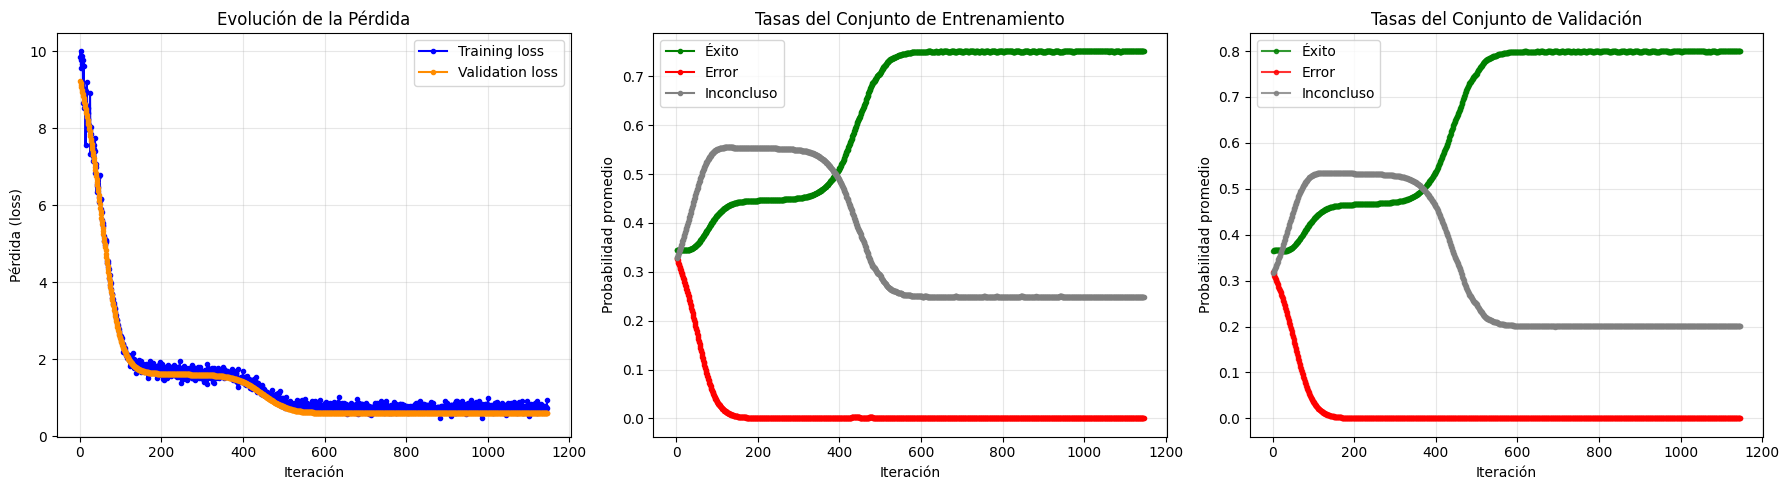

In [13]:
it = len(train_suc_history)

# Visualización de los resultados
plt.figure(figsize=(18, 5))

# 1. Evolución de la pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss", color='blue')
plt.plot(range(1, it+1), val_loss_history, '.-', label="Validation loss", color='darkorange')
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la Pérdida")
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tasas en entrenamiento
plt.subplot(1, 3, 2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito", color='green')
plt.plot(range(1, it+1), train_err_history, '.-', label="Error", color='red')
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso", color='gray')
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Entrenamiento")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Tasas en validación
plt.subplot(1, 3, 3)
plt.plot(range(1, it+1), val_suc_history, '.-', label="Éxito", color='green', alpha=0.8)
plt.plot(range(1, it+1), val_err_history, '.-', label="Error", color='red', alpha=0.8)
plt.plot(range(1, it+1), val_inc_history, '.-', label="Inconcluso", color='gray', alpha=0.8)
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Validación")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

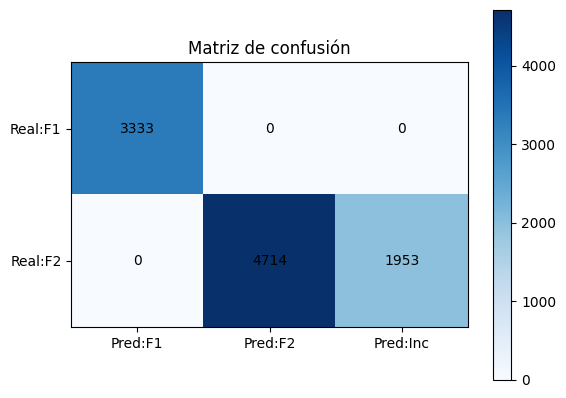

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
